# Here the goal is to combine everything Analyse

# Import all the relavant Packages

In [74]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler


In [75]:
sp = pd.read_csv('./data/sp500.csv')

it = sp[sp['GICS Sector']=='Information Technology']
cs = sp[sp['GICS Sector']=='Communication Services']
cd = sp[sp['GICS Sector']=='Consumer Discretionary']
css = sp[sp['GICS Sector']=='Consumer Staples']
hc = sp[sp['GICS Sector']=='Health Care']
df = pd.concat([it, cs, cd, css, hc], ignore_index=True)


In [76]:
df.count()

Unnamed: 0               240
Symbol                   240
Security                 240
GICS Sector              240
GICS Sub-Industry        240
Headquarters Location    240
Date added               240
CIK                      240
Founded                  240
dtype: int64

# Download Stock data from Yahoo Finance

In [317]:
import yfinance as yf
import pandas as pd
import time
from datetime import datetime, timedelta

# --- Configuration ---

tickers_list = list(df['Symbol'].values)

# 2. Set the size of each batch and the delay between batches
CHUNK_SIZE = 10  # Request 10 tickers at a time
DELAY = 2.0      # Wait 2 seconds between each request

# 3. Define the time period - updated to specific date range 2018-2024
start_date = datetime(2018, 1, 1)
end_date = datetime(2024, 12, 31)
print(f"Downloading daily data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")


# --- The Robust Download Loop ---

print(f"Starting robust download for {len(tickers_list)} tickers in chunks of {CHUNK_SIZE}...")

# List to hold the downloaded data for each chunk
all_data_chunks = []
failed_tickers = []

# Process the tickers in chunks
for i in range(0, len(tickers_list), CHUNK_SIZE):
    # Get the current chunk of tickers
    chunk = tickers_list[i:i + CHUNK_SIZE]
    
    print(f"\nDownloading chunk {i//CHUNK_SIZE + 1}/{(len(tickers_list) - 1)//CHUNK_SIZE + 1}... Tickers: {chunk}")
    
    try:
        # Download data for the current chunk
        data_chunk = yf.download(
            chunk,
            start=start_date,
            end=end_date,
            group_by='ticker',  # Keep data organized by ticker
            auto_adjust=True,   # Automatically get adjusted prices
            threads=True        # Use multiple threads for speed
        )
        
        # Check if the download returned any data
        if not data_chunk.empty:
            all_data_chunks.append(data_chunk)
        else:
            print(f"-> No data returned for chunk: {chunk}")
            failed_tickers.extend(chunk)

    except Exception as e:
        print(f"-> FAILED to download chunk: {chunk}. Error: {e}")
        failed_tickers.extend(chunk)

    # Be polite and wait before the next request
    print(f"Waiting for {DELAY} seconds...")
    time.sleep(DELAY)


# --- Final Processing ---

if all_data_chunks:
    print("\nDownload process complete. Consolidating data...")
    
    # Concatenate all the collected data chunks into one large DataFrame
    # axis=1 combines them side-by-side
    final_df = pd.concat(all_data_chunks, axis=1)
    
    # Optional: Reorder columns to have a clean multi-level index ('AAPL'/'Open', 'AAPL'/'Close', etc.)
    final_df = final_df.reindex(columns=pd.MultiIndex.from_product([tickers_list, final_df.columns.levels[1]]
                                                                   )).dropna(axis=1, how='all')

    # Save the master DataFrame to a CSV file
    final_df.to_csv('./data/stock_prices.csv')
    
    print(f"\nSUCCESS: All data successfully saved")
    
    # Also report any tickers that might have failed
    if failed_tickers:
        print(f"\nWARNING: The following tickers failed to download and are not in the file: {list(set(failed_tickers))}")
else:
    print("\nNo data was downloaded successfully.")

Starting robust download for 240 tickers in chunks of 10...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 00:00:00 -> 2024-12-31 00:00:00)')


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...



[*********************100%***********************]  10 of 10 completed


Waiting for 2.0 seconds...

Download process complete. Consolidating data...

SUCCESS: All data successfully saved


# Financial Text Analysis

### Making dataframe ready for analysis
### The goal now is to have dataframe that is ready for full ML analysis. This means I will remove any justifications and only keep the quantitative numbers that can be used by the Model



In [77]:
# Load Analysis Results to merge
df_it_porter = pd.read_csv('./data/IT_analysis/it_porter_analysis_results.csv')
df_it_power = pd.read_csv('./data/IT_analysis/it_power_analysis_results.csv')

df_cs_porter = pd.read_csv('./data/CS_analysis/cs_porter_analysis_results.csv')
df_cs_power = pd.read_csv('./data/CS_analysis/cs_power_analysis_results.csv')


df_cd_porter = pd.read_csv('./data/CD_analysis/cd_porter_analysis_results.csv')
df_cd_power = pd.read_csv('./data/CD_analysis/cd_power_analysis_results.csv')

# finally I have another dataframe with some more analysis these are for Health Care and Consumer Staples
df_hc_porter = pd.read_csv('./data/df_porter_analysis_results_1.csv')
df_hc_power = pd.read_csv('./data/df_power_analysis_results_1.csv')

# concatenate all the dataframes
df_porter = pd.concat([df_it_porter, df_cs_porter, df_cd_porter, df_hc_porter], ignore_index=True)
df_power = pd.concat([df_it_power, df_cs_power, df_cd_power, df_hc_power], ignore_index=True)


# Rename columns for clarity
df_power = df_power.rename(columns={'gemini_response': 'power_analysis'})
df_porter = df_porter.rename(columns={'gemini_response': 'porter_analysis'})


### Porter Analysis Parsing Gemini data

In [78]:
import json
import pandas as pd
import re


# Create an empty list to store the dictionaries from our parsed JSON
parsed_rows = []

print("Starting JSON parsing and cleaning...")

# Iterate through each text entry in the 'porter_analysis' column
for json_text in df_porter['porter_analysis']:
    
    # This block is the "unrolled" logic from the previous function
    
    # Handle empty or NaN values
    if pd.isna(json_text) or not str(json_text).strip():
        parsed_rows.append({}) # Append an empty dict and skip to the next iteration
        continue

    text = str(json_text)

    # --- A MORE ROBUST REGEX-BASED PATCH ---
    # This finds the specific erroneous pattern: a period, a quote, whitespace, and "aswell"
    # It replaces it with a period, a space, and "as well", effectively fixing the sentence.
    # This is better than replacing the entire long string.
    text = re.sub(r'\."\s+aswell', '. as well', text)

    # Standard cleaning to remove markdown and excess whitespace
    text = text.strip()
    if text.startswith('```json'): text = text[7:]
    elif text.startswith('```'): text = text[3:]
    if text.endswith('```'): text = text[:-3]
    text = text.strip()

    # The try/except block for parsing the cleaned text
    try:
        # If successful, parse the JSON and append the resulting dictionary
        parsed_rows.append(json.loads(text))
    except (json.JSONDecodeError, Exception) as e:
        # If parsing fails, append a dictionary containing the error for later analysis
        parsed_rows.append({'error': f"Parsing Error: {e}", 'original_text': json_text})

print("Parsing and cleaning complete.")


# --- 2. Flattening and Merging (Logic remains the same) ---

# Separate the successfully parsed dictionaries from any that returned an error
successful_data = []
successful_indices = []
for i, data in enumerate(parsed_rows):
    if 'error' not in data:
        successful_data.append(data)
        successful_indices.append(i) # Keep track of the original position

# Proceed only if there are successful rows to process
if successful_data:
    # Use json_normalize to flatten the nested 'analysis' dictionary
    # This is the most efficient way to create the columns
    normalized_df = pd.json_normalize(successful_data)
    
    # Get the original DataFrame index for the successful rows
    original_indices = df_porter.index[successful_indices]
    normalized_df.index = original_indices

    # Join the final parsed data back to the original dataframe
    # We drop 'porter_analysis' from the original df and join the new columns
    df_porter = df_porter.drop(columns=['porter_analysis']).join(normalized_df)
else:
    print("No rows were successfully parsed. df_porter will be a copy of the original DataFrame.")
    df_porter = df_porter.copy() # Avoid errors if nothing was parsed


# --- 3. Final Analysis (Logic remains the same) ---
print("\n--- Final Status ---")
# Check for an 'error' column in the final dataframe
if 'error' in df_porter.columns:
    error_count = df_porter['error'].notna().sum()
    if error_count > 0:
        print(f"\n{error_count} rows could not be parsed.")
        print("--- Rows That Still Have Parsing Errors ---")
        pd.set_option('display.max_colwidth', 80)
        print(df_porter[df_porter['error'].notna()][['error']])
    else:
        print("\n✅ All rows parsed successfully!")
else:
    print("\n✅ All rows parsed successfully!")

# Create a list of new columns that were added
new_cols = [col for col in df_porter.columns if col not in df_porter.columns]
# Add back a couple of key columns for context if they exist
if 'primary_force' in df_porter.columns: new_cols.insert(0, 'primary_force')
if 'threat_level.threat_of_new_entrants' in df_porter.columns: new_cols.insert(1, 'threat_level.threat_of_new_entrants')
    
# Filter out columns that might not exist in all runs to prevent KeyErrors
existing_new_cols = [col for col in new_cols if col in df_porter.columns]

Starting JSON parsing and cleaning...
Parsing and cleaning complete.

--- Final Status ---

✅ All rows parsed successfully!


### Parse Hamilton's 7 Power

In [79]:
# Create an empty list to store the dictionaries from our parsed JSON
parsed_rows = []


COLUMN_TO_PARSE = 'power_analysis' 

print(f"Starting JSON parsing and cleaning for column: '{COLUMN_TO_PARSE}'...")

# Iterate through each text entry in the specified column
# Make sure your DataFrame is named 'merged_df' or change it below
for json_text in df_power[COLUMN_TO_PARSE]:
    
    # Handle empty or NaN values
    if pd.isna(json_text) or not str(json_text).strip():
        parsed_rows.append({}) # Append an empty dict and skip
        continue

    text = str(json_text)

    # --- A MORE ROBUST REGEX-BASED PATCH ---
    # can be added here.

    # Standard cleaning to remove markdown and excess whitespace
    text = text.strip()
    if text.startswith('```json'): text = text[7:]
    elif text.startswith('```'): text = text[3:]
    if text.endswith('```'): text = text[:-3]
    text = text.strip()

    # The try/except block for parsing the cleaned text
    try:
        # If successful, parse the JSON and append the resulting dictionary
        parsed_rows.append(json.loads(text))
    except (json.JSONDecodeError, Exception) as e:
        # If parsing fails, append a dictionary containing the error for later analysis
        parsed_rows.append({'error': f"Parsing Error: {e}", 'original_text': json_text})

print("Parsing and cleaning complete.")


# --- 2. Flattening and Merging ---

# Separate the successfully parsed dictionaries from any that returned an error
successful_data = []
successful_indices = []
for i, data in enumerate(parsed_rows):
    # Ensure the dictionary is not empty and has no errors
    if data and 'error' not in data:
        successful_data.append(data)
        successful_indices.append(i) # Keep track of the original position

# Proceed only if there are successful rows to process
if successful_data:
    # Use json_normalize to automatically flatten the entire nested structure.
    # It will create columns like 'analysis.scale_economies.confidence_of_fit'
    normalized_df = pd.json_normalize(successful_data)
    
    # Optional: Clean up column names by removing the leading 'analysis.' prefix
    normalized_df.columns = [col.replace('analysis.', '') for col in normalized_df.columns]
    
    # Get the original DataFrame index for the successful rows to ensure correct alignment
    original_indices = df_power.index[successful_indices]
    normalized_df.index = original_indices

    # Join the final parsed data back to the original dataframe
    # We drop the original JSON column and join the new flattened columns
    df_power = df_power.drop(columns=[COLUMN_TO_PARSE]).join(normalized_df)
else:
    print("No rows were successfully parsed. df_power will be a copy of the original DataFrame.")
    df_power = df_power.copy()


# --- 3. Final Analysis ---
print("\n--- Final Status ---")
# Check for an 'error' column in the final dataframe
if 'error' in df_power.columns:
    error_count = df_power['error'].notna().sum()
    if error_count > 0:
        print(f"\n{error_count} rows could not be parsed.")
        print("--- Rows That Still Have Parsing Errors ---")
        print(df_power[df_power['error'].notna()][['error']])
    else:
        print("\n✅ All rows parsed successfully!")
else:
    print("\n✅ All rows parsed successfully!")


# Create a list of new columns to display in the sample
# This will show the top-level fields and some key flattened fields
sample_cols = [
    'primary_power',
    'power_timing',
    'scale_economies.power_strength',
    'switching_costs.power_strength',
    'process_power.power_strength',
    'branding.power_strength'
]
    
# Filter out columns that might not exist in the final df to prevent KeyErrors
existing_sample_cols = [col for col in sample_cols if col in df_power.columns]


Starting JSON parsing and cleaning for column: 'power_analysis'...
Parsing and cleaning complete.

--- Final Status ---

✅ All rows parsed successfully!


### Making sure there are no empty cells
### Making sure to remove textual data
### Making sure to remove non-necessary data for the analysis section

In [80]:
# Calculate the minimum number of non-empty values required to keep a row (51% of total columns)
min_non_empty_values = int(len(df_porter.columns) * 0.51)
# Drop rows that do not meet this threshold
porter_analysis = df_porter.dropna(axis=0, thresh=min_non_empty_values)

# Get a list of columns that end with .relevant_quotes or .justification
cols_to_drop = [col for col in porter_analysis.columns if col.endswith(('.relevant_quotes', '.justification'))]
# Drop these columns from df_porter
porter_analysis = porter_analysis.drop(columns=cols_to_drop)

porter_analysis = porter_analysis.drop(columns=['ticker','content','Headquarters Location','Unnamed: 0','overall_summary','CIK','Date added','Founded','porter_prompt'])

# Calculate the minimum number of non-empty values required to keep a row (51% of total columns)
min_non_empty_values = int(len(df_power.columns) * 0.51)

# Drop rows that do not meet this threshold
power_analysis = df_power.dropna(axis=0, thresh=min_non_empty_values)

# Get a list of columns that end with any of the specified suffixes
suffixes_to_remove = ['.swot_classification', '.relevant_quotes', '.key_indicators', '.justification']
cols_to_drop = [col for col in power_analysis.columns if any(col.endswith(suffix) for suffix in suffixes_to_remove)]

# Drop these columns from power_analysis
power_analysis = power_analysis.drop(columns=cols_to_drop)

power_analysis = power_analysis.drop(columns=['ticker','content','Founded','Headquarters Location','Unnamed: 0','overall_summary','CIK','porter_prompt','seven_powers_prompt','primary_power_timing','Date added'])


### Power Analysis

### In the interest of making all the data quantitative for the LM model I will be switching the textual answers into numerical ones. 

For the threat level we have 
- Low -> 0.1
- Medium -> 0.5
- High -> 1
- Not Applicable -> 0.0

For Gemini answers as Moderate I will convert it to Medium and for answers that are in between (Moderate-High) I will only consider the 

In [81]:
# Find all columns that end with '.threat_level'
threat_level_cols = [col for col in porter_analysis.columns if col.endswith('.threat_level')]

# Create combined mapping dictionary - standardize and convert to numerical in one step
threat_level_mapping = {
    'High': 1.0,
    'Medium': 0.5,
    'Low': 0.1,
    'Not Applicable': 0.0,
    'Moderate': 0.5,           # Moderate -> Medium -> 0.5
    'Moderate-High': 0.5,      # Conservative: Moderate-High -> Medium -> 0.5
    'Medium-Low': 0.1,          # Medium-Low -> Low -> 0.1
    'Medium-High': 0.5,      # Medium-High -> Medium -> 0.5
    'High-Moderate': 0.5,      # High-Moderate -> Medium -> 0.5
}

# Apply mapping to all threat level columns
for col in threat_level_cols:
    porter_analysis[col] = porter_analysis[col].map(threat_level_mapping)

# Optional: Check the updated numerical values
print("Threat level columns converted to numerical values:")

Threat level columns converted to numerical values:


### Now the idea is to merge the analysis dataframe from porter's 5 Forces and Power and turn all the values into numerical ones for the ML model

In [82]:
# Merge the two dataframes on shared metadata columns
merged_analysis = porter_analysis.merge(
    power_analysis, 
    on=['filing_date', 'section', 'Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry'],
    how='inner'  # Change to 'outer' if you want to keep records that don't match in both
)


# Define metadata/text columns to keep at the beginning
metadata_cols = [
    'filing_date', 'section', 'Symbol', 'Security', 'GICS Sector', 
    'GICS Sub-Industry', 'primary_force', 'primary_power', 'power_timing'
]

# Get all numerical analysis columns (everything else)
numerical_cols = [col for col in merged_analysis.columns if col not in metadata_cols]

# Reorder the dataframe with metadata first, then numerical columns
column_order = metadata_cols + numerical_cols
merged_analysis = merged_analysis[column_order]

In [83]:
# Define meta columns that should remain as strings
meta_columns = [
    'filing_date',
    'section', 
    'Symbol',
    'Security',
    'GICS Sector',
    'GICS Sub-Industry',
    'primary_force',
    'primary_power', 
    'power_timing'
]

# Get all column names
all_columns = merged_analysis.columns.tolist()

# Identify analysis columns (all columns except meta columns)
analysis_columns = [col for col in all_columns if col not in meta_columns]

print(f"Meta columns ({len(meta_columns)}): {meta_columns}")
print(f"\nAnalysis columns ({len(analysis_columns)}): {analysis_columns[:5]}...")  # Show first 5

# Convert analysis columns to float
for col in analysis_columns:
    try:
        merged_analysis[col] = merged_analysis[col].astype(float)
        print(f"Converted {col} to float")
    except Exception as e:
        print(f"Error converting {col}: {e}")

# Verify the data types
print(f"\nData types after conversion:")
print(merged_analysis.dtypes)

# Check for any remaining non-numeric values in analysis columns
print(f"\nChecking for non-numeric values in analysis columns:")
for col in analysis_columns:
    non_numeric = merged_analysis[col].apply(lambda x: not isinstance(x, (int, float)) and not pd.isna(x))
    if non_numeric.any():
        print(f"{col}: {non_numeric.sum()} non-numeric values")
        print(f"Examples: {merged_analysis[non_numeric][col].unique()[:5]}")
    else:
        print(f"{col}: All values are numeric or NaN")

Meta columns (9): ['filing_date', 'section', 'Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'primary_force', 'primary_power', 'power_timing']

Analysis columns (24): ['analysis.threat_of_new_entrants.confidence_of_fit', 'analysis.threat_of_new_entrants.threat_level', 'analysis.bargaining_power_of_buyers.confidence_of_fit', 'analysis.bargaining_power_of_buyers.threat_level', 'analysis.bargaining_power_of_suppliers.confidence_of_fit']...
Converted analysis.threat_of_new_entrants.confidence_of_fit to float
Converted analysis.threat_of_new_entrants.threat_level to float
Converted analysis.bargaining_power_of_buyers.confidence_of_fit to float
Converted analysis.bargaining_power_of_buyers.threat_level to float
Converted analysis.bargaining_power_of_suppliers.confidence_of_fit to float
Converted analysis.bargaining_power_of_suppliers.threat_level to float
Converted analysis.threat_of_substitute_products.confidence_of_fit to float
Converted analysis.threat_of_substitute_products.thr

In [84]:
# Simple automatic confidence analysis for all frameworks
# Apply 80% confidence threshold logic automatically

# Create a copy to work with
complete_analysis = merged_analysis.copy()

# Set confidence threshold
confidence_threshold = 0.80

print(f"Applying {confidence_threshold*100}% confidence threshold automatically...")
print("=" * 60)

# Find all confidence columns automatically
confidence_columns = [col for col in complete_analysis.columns if 'confidence_of_fit' in col]

# Process each confidence column
for confidence_col in confidence_columns:
    # Derive the corresponding value column name
    if 'analysis.' in confidence_col:
        # Porter's Forces: replace confidence_of_fit with threat_level
        value_col = confidence_col.replace('confidence_of_fit', 'threat_level')
    else:
        # 7 Powers: replace confidence_of_fit with power_strength
        value_col = confidence_col.replace('confidence_of_fit', 'power_strength')
    
    # Check if the value column exists
    if value_col in complete_analysis.columns:
        # Count values before filtering
        original_count = (complete_analysis[value_col] > 0).sum()
        
        # Apply logic: if confidence < threshold, set value to 0
        mask = complete_analysis[confidence_col] < confidence_threshold
        complete_analysis.loc[mask, value_col] = 0
        
        # Count values after filtering
        filtered_count = (complete_analysis[value_col] > 0).sum()
        
        # Extract framework name for display
        framework_name = confidence_col.replace('.confidence_of_fit', '').replace('analysis.', '')
        
        print(f"{framework_name}: {filtered_count}/{original_count} kept ({filtered_count/original_count*100:.1f}%)")
    else:
        print(f"Warning: No matching value column for {confidence_col}")

# Drop all confidence columns
complete_analysis = complete_analysis.drop(columns=confidence_columns)


print(f"Complete! Processed {len(confidence_columns)} frameworks")



Applying 80.0% confidence threshold automatically...
threat_of_new_entrants: 617/847 kept (72.8%)
bargaining_power_of_buyers: 524/712 kept (73.6%)
bargaining_power_of_suppliers: 472/847 kept (55.7%)
threat_of_substitute_products: 289/476 kept (60.7%)
intensity_of_rivalry: 611/816 kept (74.9%)
scale_economies: 561/933 kept (60.1%)
network_economies: 86/273 kept (31.5%)
counter_positioning: 50/203 kept (24.6%)
switching_costs: 271/652 kept (41.6%)
branding: 311/817 kept (38.1%)
cornered_resource: 271/850 kept (31.9%)
process_power: 621/1070 kept (58.0%)
Complete! Processed 12 frameworks


In [85]:
complete_analysis = complete_analysis.drop(columns=['primary_force', 'primary_power', 'power_timing'])

In [86]:
# Group complete_analysis by Symbol and sum all numerical analysis columns
print("Grouping analysis data by Symbol...")

# Identify numerical analysis columns to sum
numerical_cols = [col for col in complete_analysis.columns
                 if col.endswith(('.threat_level', '.power_strength'))]

# Identify meta columns to keep (take first value for each symbol)
meta_cols = [col for col in complete_analysis.columns
            if col not in numerical_cols and col != 'Symbol']

print(f"Found {len(numerical_cols)} numerical columns to sum")
print(f"Found {len(meta_cols)} meta columns to preserve")

# Create aggregation dictionary
agg_dict = {}

# For numerical columns: sum
for col in numerical_cols:
    agg_dict[col] = 'sum'

# For meta columns: take first (they should be the same for each symbol)
for col in meta_cols:
    agg_dict[col] = 'first'

# Group by Symbol and aggregate
complete_analysis = complete_analysis.groupby('Symbol').agg(agg_dict).reset_index()

print(f"Grouping complete!")

# Rearrange columns: meta columns first, then numerical columns
column_order = ['Symbol'] + meta_cols + numerical_cols
complete_analysis = complete_analysis[column_order]

Grouping analysis data by Symbol...
Found 12 numerical columns to sum
Found 5 meta columns to preserve
Grouping complete!


In [87]:
complete_analysis.head(10).T

,0,1,2,3,4,5,6,7,8,9
Symbol,A,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADM,ADSK
filing_date,2024-10-31,2024-09-28,2024-12-31,2024-12-31,2024-12-31,2024-08-31,2024-11-29,2024-11-02,2024-12-31,2025-01-31
section,Item 1. Business,Item 1. Business,Item 1. Business,Item 1. Business,Item 1. Business,Item 1. Business,Item 1. Business,Item 1. Business,Item 1. Business,Item 1. Business
Security,Agilent Technologies,Apple Inc.,AbbVie,Airbnb,Abbott Laboratories,Accenture,Adobe Inc.,Analog Devices,Archer Daniels Midland,Autodesk
GICS Sector,Health Care,Information Technology,Health Care,Consumer Discretionary,Health Care,Information Technology,Information Technology,Information Technology,Consumer Staples,Information Technology
GICS Sub-Industry,Life Sciences Tools & Services,"Technology Hardware, Storage & Peripherals",Biotechnology,"Hotels, Resorts & Cruise Lines",Health Care Equipment,IT Consulting & Other Services,Application Software,Semiconductors,Agricultural Products & Services,Application Software
analysis.threat_of_new_entrants.threat_level,0.2,1.2,0.3,0.3,0.2,1.3,1.2,0.5,0.3,1.1
analysis.bargaining_power_of_buyers.threat_level,2.1,2.0,3.0,1.2,3.0,2.6,0.2,3.0,2.1,1.1
analysis.bargaining_power_of_suppliers.threat_level,0.0,3.0,1.0,1.6,1.1,1.5,0.0,1.0,1.1,1.0
analysis.threat_of_substitute_products.threat_level,0.0,0.0,2.0,1.1,1.0,2.1,1.1,0.0,2.0,0.1


In [88]:
text_analysis = complete_analysis.copy()
text_analysis = text_analysis.drop(columns=['section', 'GICS Sector','GICS Sub-Industry','Security'])
text_analysis = text_analysis.rename(columns={
    'Symbol': 'ticker',
    'filing_date': 'filed',
})

# Reddit data

In [89]:
rd = pd.read_csv('./data/reddit_analysis_results.csv')
rd1 = pd.read_csv('./data/reddit_analysis_results_1819.csv')
rd2 = pd.read_csv('./data/reddit_analysis_results_25.csv')
rd = pd.concat([rd, rd1, rd2], ignore_index=True)
rd = rd.rename(columns={'gemini_response': 'reddit_analysis'})
rd = rd.drop(columns=['reddit_sentiment_prompt','comments','is_self','flair'])

In [90]:
rd.head(10)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,post_id,title,...,score,upvote_ratio,created_utc,num_comments,author,url,subreddit,category,year,reddit_analysis
0,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977,mceprg,It's not just me right?,...,6957,0.92,2021-03-24,2760,calipfarris01,https://www.reddit.com/r/stocks/comments/mcepr...,stocks,stock_specific,2021,"{\n ""post_summary"": {\n ""thesis"": ""The ori..."
1,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977,rrhoka,To all of you who are red this year while the ...,...,5852,0.91,2021-12-29,1156,karnoculars,https://www.reddit.com/r/stocks/comments/rrhok...,stocks,stock_specific,2021,"{\n ""post_summary"": {\n ""thesis"": ""The ori..."
2,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977,ja9wv0,"I have $213,000 in Apple (AAPL) stock, should ...",...,2461,0.93,2020-10-13,727,sleeping_in_,https://www.reddit.com/r/stocks/comments/ja9wv...,stocks,stock_specific,2020,"{\n ""post_summary"": {\n ""thesis"": ""The aut..."
3,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977,qkmmmq,"If you could put 3k into AAPL, MSFT, or FB, wh...",...,623,0.89,2021-11-01,712,DippySwitch,https://www.reddit.com/r/stocks/comments/qkmmm...,stocks,stock_specific,2021,"{\n ""post_summary"": {\n ""thesis"": ""The ori..."
4,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977,18s30mt,"Whats your ""this could be the next tsla or aap...",...,274,0.78,2023-12-27,545,rpatel09,https://www.reddit.com/r/stocks/comments/18s30...,stocks,stock_specific,2023,"{\n ""post_summary"": {\n ""thesis"": ""The ori..."
5,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977,ukldms,How far do you think MSFT and AAPL could fall?,...,514,0.92,2022-05-07,526,apooroldinvestor,https://www.reddit.com/r/stocks/comments/ukldm...,stocks,stock_specific,2022,"{\n ""post_summary"": {\n ""thesis"": ""The ori..."
6,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977,1ciq1fw,Apple announces largest-ever $110 billion shar...,...,2990,0.94,2024-05-02,522,Puginator,https://www.reddit.com/r/stocks/comments/1ciq1...,stocks,stock_specific,2024,"{\n ""post_summary"": {\n ""thesis"": ""Apple r..."
7,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977,wqy6lj,I SOLD AAPL :(,...,834,0.85,2022-08-17,433,amoottake,https://www.reddit.com/r/stocks/comments/wqy6l...,stocks,stock_specific,2022,"{\n ""post_summary"": {\n ""thesis"": ""The aut..."
8,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977,zsuvnl,AAPL is at 52-week low!,...,870,0.88,2022-12-22,399,paq12x,https://www.reddit.com/r/stocks/comments/zsuvn...,stocks,stock_specific,2022,"{\n ""post_summary"": {\n ""thesis"": ""The ori..."
9,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977,16cfl90,"China plans to expand its ban on iPhones, AAPL...",...,772,0.94,2023-09-07,398,msaleem,https://www.reddit.com/r/stocks/comments/16cfl...,stocks,stock_specific,2023,"{\n ""post_summary"": {\n ""thesis"": ""The ori..."


In [91]:
import json
import pandas as pd

# --- 1. Parse Text with Error Reporting and Row Removal ---

# We will now store tuples of (index, data) to keep track of the original index
parsed_data_with_indices = []
# !!! IMPORTANT: Replace 'your_text_column_name' with the actual name of your column
COLUMN_TO_PARSE = 'reddit_analysis'

print(f"Starting text parsing for column: '{COLUMN_TO_PARSE}' with error reporting...")

# We will use .iterrows() to get the index for better error messages
for index, row in rd.iterrows():
    text_data = row[COLUMN_TO_PARSE]
    
    # Handle any potential null/empty values
    if pd.isna(text_data) or not str(text_data).strip():
        # This will skip null rows as before
        continue

    text = str(text_data).strip()
    
    # This try/except block is for debugging. It will find and print any bad rows.
    try:
        # On success, append a tuple of the original index and the parsed dictionary
        parsed_data_with_indices.append((index, json.loads(text)))
    except json.JSONDecodeError as e:
        # --- MODIFICATION START ---
        # This code now runs ONLY if a row is not valid JSON.
        # Instead of saving an error, we print the message and skip the row.
        print("-" * 60)
        print(f"!!! JSON FORMAT ERROR FOUND at index: {index} - ROW SKIPPED !!!")
        print(f"Error Message: {e}")
        continue # Skip to the next row in the loop
        # --- MODIFICATION END ---

# --- 2. Normalize and Create Final DataFrame ---

print(f"\nParsing complete. Found {len(parsed_data_with_indices)} valid rows to process.")

if parsed_data_with_indices:
    # --- MODIFICATION START ---
    # Separate the indices and the data from our list of tuples
    original_indices = [item[0] for item in parsed_data_with_indices]
    successful_data = [item[1] for item in parsed_data_with_indices]

    # Normalize the successful data as before
    normalized_df = pd.json_normalize(successful_data)
    
    # Set the DataFrame index to the original indices we saved
    normalized_df.index = original_indices
    # --- MODIFICATION END ---

    # Get the subset of the original DataFrame that corresponds to our successful rows
    original_data_subset = rd.loc[original_indices].drop(columns=[COLUMN_TO_PARSE])
    
    # Concatenate the original data (minus the parsed column) with the new normalized columns
    rd_final = pd.concat([original_data_subset, normalized_df], axis=1)

    print(f"Created {len(normalized_df.columns)} new columns from the text data.")
    print("\n--- Sample of Successfully Parsed Data ---")
    sample_cols = [
        'market_outlook', 'post_summary.thesis', 'quantitative_analysis.sentiment_score'
    ]
    existing_sample_cols = [col for col in sample_cols if col in rd_final.columns]
    # This check is just to prevent an error if sample columns don't exist
    if existing_sample_cols:
        print(rd_final[existing_sample_cols].head())

else:
    print("No rows were successfully parsed.")

Starting text parsing for column: 'reddit_analysis' with error reporting...
------------------------------------------------------------
!!! JSON FORMAT ERROR FOUND at index: 1618 - ROW SKIPPED !!!
Error Message: Expecting ':' delimiter: line 5 column 26 (char 615)
------------------------------------------------------------
!!! JSON FORMAT ERROR FOUND at index: 1673 - ROW SKIPPED !!!
Error Message: Expecting ':' delimiter: line 5 column 26 (char 517)
------------------------------------------------------------
!!! JSON FORMAT ERROR FOUND at index: 3354 - ROW SKIPPED !!!
Error Message: Expecting ':' delimiter: line 5 column 25 (char 816)
------------------------------------------------------------
!!! JSON FORMAT ERROR FOUND at index: 3766 - ROW SKIPPED !!!
Error Message: Expecting ':' delimiter: line 6 column 3 (char 404)

Parsing complete. Found 4424 valid rows to process.
Created 37 new columns from the text data.

--- Sample of Successfully Parsed Data ---
  market_outlook         

I have a lot of columns with a lot of NaN values (Not all of them are empty) in my cell so I will need to remove them all. Instead of removing column one by one I will simply remove all the columns that are majority empty. 

In [92]:
# Calculate the percentage of NaN values in each column
nan_percentages = rd_final.isna().mean()

# Get columns that have more than 95% NaN values
columns_to_drop = nan_percentages[nan_percentages > 0.95].index

# Drop these columns
rd_final = rd_final.drop(columns=columns_to_drop)


# Drop specific columns that are not needed
rd_final = rd_final.drop(columns=['Headquarters Location','Date added','CIK','Founded'])


In [93]:
rd_final.head().T

,0,1,2,3,4
Symbol,AAPL,AAPL,AAPL,AAPL,AAPL
Security,Apple Inc.,Apple Inc.,Apple Inc.,Apple Inc.,Apple Inc.
GICS Sector,Information Technology,Information Technology,Information Technology,Information Technology,Information Technology
GICS Sub-Industry,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals"
post_id,mceprg,rrhoka,ja9wv0,qkmmmq,18s30mt
title,It's not just me right?,To all of you who are red this year while the ...,"I have $213,000 in Apple (AAPL) stock, should ...","If you could put 3k into AAPL, MSFT, or FB, wh...","Whats your ""this could be the next tsla or aap..."
post,For the past month I've been getting absolutel...,Lately I keep hearing the same old narrative f...,"I always tell myself to stop buying Apple, but...",I’m looking for a “safe” place to put 3k. Argu...,Just like the title says.... what are people's...
score,6957,5852,2461,623,274
upvote_ratio,0.92,0.91,0.93,0.89,0.78
created_utc,2021-03-24,2021-12-29,2020-10-13,2021-11-01,2023-12-27


I have at least 1 datapoint per week and have a maximum of 40 posts per week. We need to condense the results weekly so we can analyze them alongside other datapoints

### How many datapoints do I have every week. This is important to have enough data-points every week or do a normalization function before merging with the model

Complete Weekly Analysis (2018-2024):
Total weeks in period: 366
Weeks WITH data: 361
Weeks with NO data: 5
Percentage of weeks with data: 98.6%
Percentage of weeks with NO data: 1.4%

First few weeks with no data: ['2018-W27', '2018-W46', '2019-W21', '2019-W27', '2019-W52']
Last few weeks with no data: ['2018-W27', '2018-W46', '2019-W21', '2019-W27', '2019-W52']

Statistics for ALL weeks (including zeros):
Maximum posts in any week: 50
Average posts per week (including zero weeks): 10.75
Average posts per week (only weeks with data): 10.90


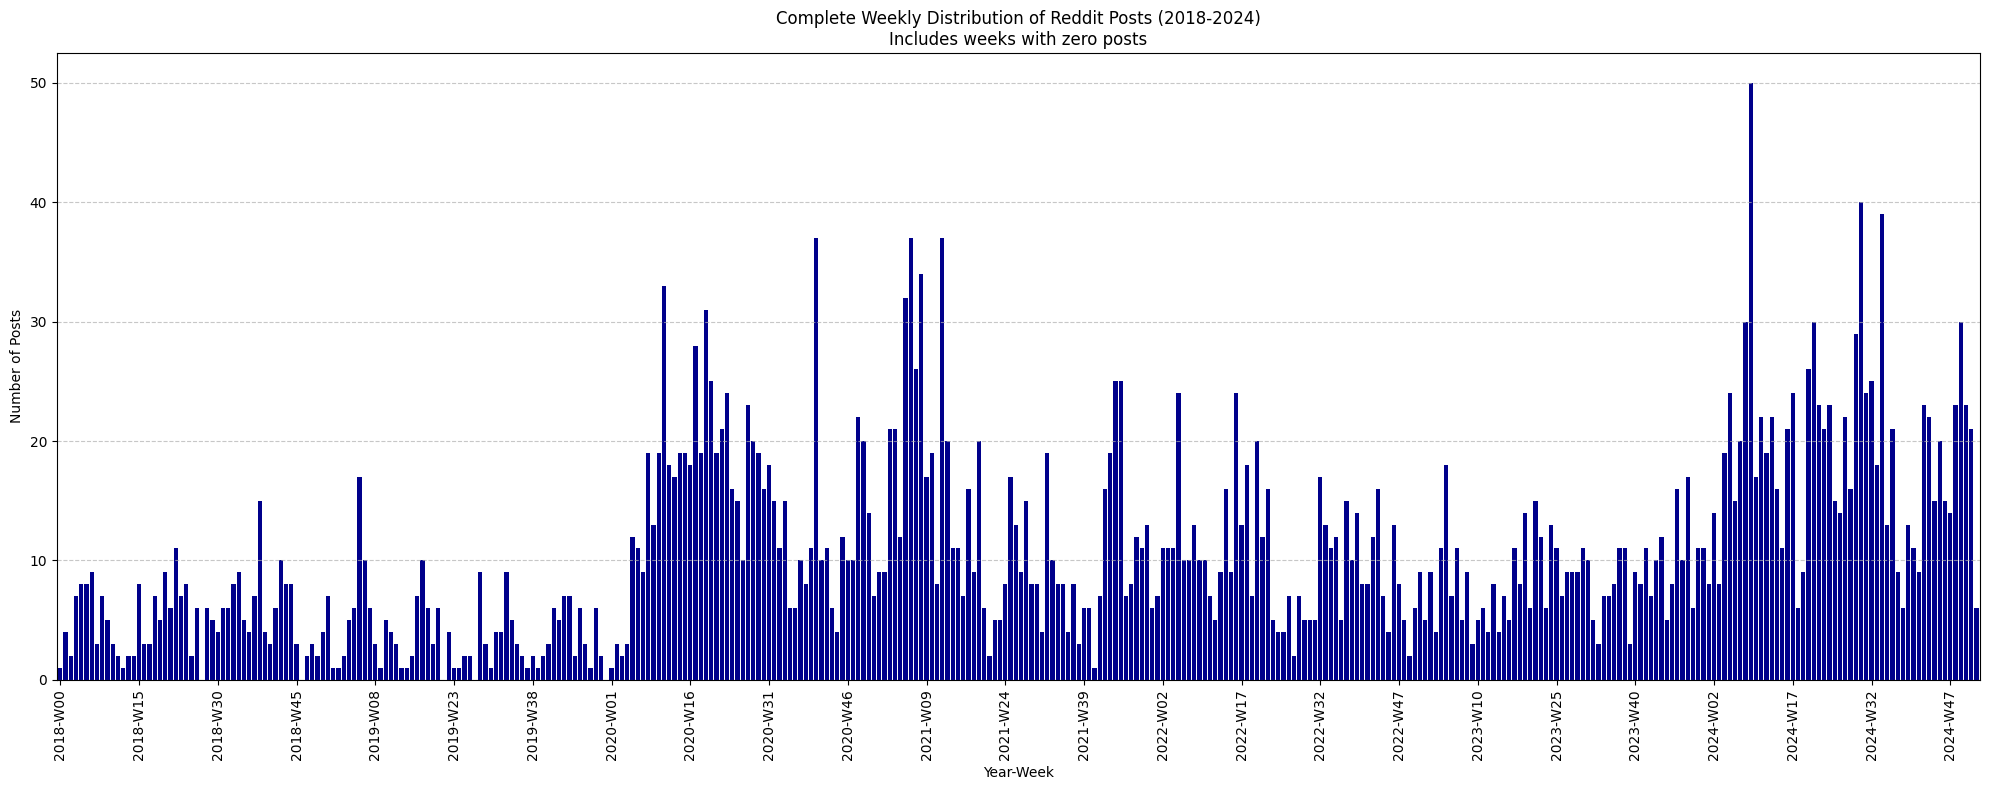

In [94]:
# Convert the created_utc column to datetime format for better analysis
rd_final['created_utc'] = pd.to_datetime(rd_final['created_utc'])

# Extract week information
rd_final['year_week'] = rd_final['created_utc'].dt.strftime('%Y-W%U')

# Get the actual weekly distribution from your data
actual_weekly_distribution = rd_final['year_week'].value_counts().sort_index()

# Create a complete linear weekly timeline from 2018 to 2024


# Create complete date range from start of 2018 to end of 2024
start_date = datetime(2018, 1, 1)
end_date = datetime(2024, 12, 31)

# Generate all weeks in this range
all_weeks = []
current_date = start_date
while current_date <= end_date:
    week_label = current_date.strftime('%Y-W%U')
    all_weeks.append(week_label)
    current_date += timedelta(weeks=1)

# Convert to pandas Series for easier handling
complete_weekly_timeline = pd.Series(index=all_weeks, data=0)

# Fill in actual data where it exists
for week, count in actual_weekly_distribution.items():
    if week in complete_weekly_timeline.index:
        complete_weekly_timeline[week] = count

# Analysis of missing data
weeks_with_data = (complete_weekly_timeline > 0).sum()
weeks_with_no_data = (complete_weekly_timeline == 0).sum()
total_weeks = len(complete_weekly_timeline)

print("Complete Weekly Analysis (2018-2024):")
print(f"Total weeks in period: {total_weeks}")
print(f"Weeks WITH data: {weeks_with_data}")
print(f"Weeks with NO data: {weeks_with_no_data}")
print(f"Percentage of weeks with data: {(weeks_with_data/total_weeks)*100:.1f}%")
print(f"Percentage of weeks with NO data: {(weeks_with_no_data/total_weeks)*100:.1f}%")

# Find consecutive periods of missing data
missing_weeks = complete_weekly_timeline[complete_weekly_timeline == 0].index.tolist()
print(f"\nFirst few weeks with no data: {missing_weeks[:10]}")
print(f"Last few weeks with no data: {missing_weeks[-10:]}")

# Create visualization showing ALL weeks including zeros
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
complete_weekly_timeline.plot(kind='bar', color='darkblue', width=0.8)
plt.title('Complete Weekly Distribution of Reddit Posts (2018-2024)\nIncludes weeks with zero posts')
plt.xlabel('Year-Week')
plt.ylabel('Number of Posts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)

# Show every nth tick to avoid overcrowding
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))
plt.tight_layout()

# Additional statistics
print(f"\nStatistics for ALL weeks (including zeros):")
print(f"Maximum posts in any week: {complete_weekly_timeline.max()}")
print(f"Average posts per week (including zero weeks): {complete_weekly_timeline.mean():.2f}")
print(f"Average posts per week (only weeks with data): {complete_weekly_timeline[complete_weekly_timeline > 0].mean():.2f}")

plt.show()


Total companies with Reddit posts: 137

Top 20 companies by post count:


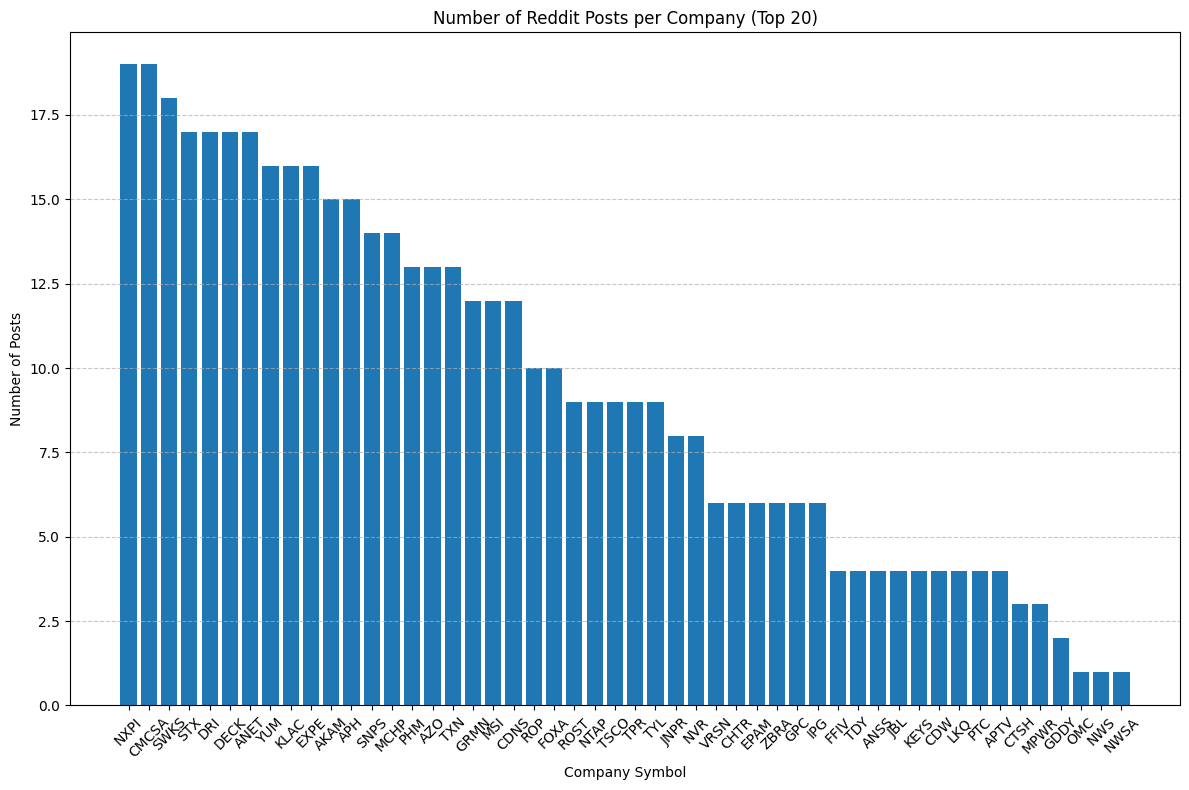

In [95]:
# Count the number of reddit posts per company (Symbol)
reddit_posts_per_company = rd_final.groupby('Symbol').size().reset_index(name='post_count')

# Sort by post count in descending order
reddit_posts_per_company = reddit_posts_per_company.sort_values('post_count', ascending=False)

# Display the result
print(f"Total companies with Reddit posts: {len(reddit_posts_per_company)}")
print("\nTop 20 companies by post count:")

# Optional: Create a bar chart visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
top_companies = reddit_posts_per_company.tail(50)
plt.bar(top_companies['Symbol'], top_companies['post_count'])
plt.xticks(rotation=45)
plt.title('Number of Reddit Posts per Company (Top 20)')
plt.xlabel('Company Symbol')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# DCF analysis

### DCF Data Extraction and Processing Code Explanation
This code extracts and processes financial data for Discounted Cash Flow (DCF) analysis from company financial statements. It's part of a larger hybrid pricing model that combines financial analysis with sentiment and industry analysis.

In [96]:
import pandas as pd
import json
import os

# Load the DCF mapping file
with open('dcf.json', 'r') as f:
    dcf_mapping = json.load(f)

# Create output directory for DCF files
output_dir = './data/company_dcf_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Corporate tax rate
tax_rate = 0.25

# Process each company
for idx, row in df.iterrows():
    symbol = row['Symbol']
    sub_industry = row['GICS Sub-Industry']
    
    # Convert sub-industry to Pascal case
    # Replace & with And
    pascal_industry = sub_industry.replace('&', 'And')
    # Remove special characters and capitalize each word
    words = pascal_industry.replace(',', '').replace('-', ' ').split()
    pascal_industry = ''.join(word.capitalize() for word in words)
    
    # Check if this industry exists in dcf_mapping
    if pascal_industry not in dcf_mapping:
        print(f"Industry {pascal_industry} not found in DCF mapping for {symbol}")
        continue
    
    # Get the DCF components for this industry
    industry_dcf = dcf_mapping[pascal_industry]
    
    # Load company's master.csv
    file_path = f'./data/financial_statement/{symbol}_master.csv'
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # Read the company data
    company_data = pd.read_csv(file_path)
    
    # Create a dictionary to store DCF data
    dcf_results = {}
    
    # Extract each DCF component
    for component_name, account_list in industry_dcf.items():
        for account in account_list:
            # Check if this account exists in the company data columns
            if account in company_data.columns:
                # Add to results with component prefix
                column_name = f"{component_name}_{account}"
                dcf_results[column_name] = company_data[account]
    
    # Convert to DataFrame
    if dcf_results:
        company_dcf_df = pd.DataFrame(dcf_results)
        
        # Add the frame and filed columns if they exist
        if 'frame' in company_data.columns:
            company_dcf_df.insert(0, 'frame', company_data['frame'])
        if 'filed' in company_data.columns:
            company_dcf_df.insert(1, 'filed', company_data['filed'])
        
        # Filter to keep only 2018 and later data
        # Extract year from frame (e.g., CY2019 -> 2019)
        company_dcf_df['year'] = company_dcf_df['frame'].str.extract('(\d{4})')
        company_dcf_df['year'] = pd.to_numeric(company_dcf_df['year'])
        
        # Keep only rows from 2018 onwards
        company_dcf_df = company_dcf_df[company_dcf_df['year'] >= 2018]
        
        # === FCF CALCULATION STARTS HERE ===
        # Create a copy of columns we want to preserve before any dropping operations
        preserve_cols = ['frame', 'filed', 'year']
        preserved_data = {col: company_dcf_df[col] for col in preserve_cols if col in company_dcf_df.columns}
        
        # Get non-NaN columns for calculations only
        calc_df = company_dcf_df.dropna(axis=1, how='all')
        
        # Calculate FCF components
        # 1. Revenue
        revenue_cols = [col for col in calc_df.columns if col.startswith('revenue_')]
        company_dcf_df['FCF_Revenue'] = calc_df[revenue_cols].sum(axis=1) if revenue_cols else 0
        
        # 2. COGS
        cogs_cols = [col for col in company_dcf_df.columns if col.startswith('cogs_')]
        company_dcf_df['FCF_COGS'] = company_dcf_df[cogs_cols].sum(axis=1) if cogs_cols else 0
        
        # 3. Operating Expenses
        opex_cols = [col for col in company_dcf_df.columns if col.startswith('operating_expenses_')]
        company_dcf_df['FCF_OpEx'] = company_dcf_df[opex_cols].sum(axis=1) if opex_cols else 0
        
        # 4. EBIT
        company_dcf_df['FCF_EBIT'] = company_dcf_df['FCF_Revenue'] - company_dcf_df['FCF_COGS'] - company_dcf_df['FCF_OpEx']
        
        # 5. NOPAT
        company_dcf_df['FCF_NOPAT'] = company_dcf_df['FCF_EBIT'] * (1 - tax_rate)
        
        # 6. Depreciation & Amortization
        da_cols = [col for col in company_dcf_df.columns if col.startswith('d_and_a_')]
        company_dcf_df['FCF_DA'] = company_dcf_df[da_cols].sum(axis=1) if da_cols else 0
        
        # 7. Capex (make positive for subtraction)
        capex_cols = [col for col in company_dcf_df.columns if col.startswith('capex_')]
        company_dcf_df['FCF_Capex'] = company_dcf_df[capex_cols].sum(axis=1).abs() if capex_cols else 0
        
        # 8. Stock Based Compensation
        sbc_cols = [col for col in company_dcf_df.columns if col.startswith('stock_based_compensation_')]
        company_dcf_df['FCF_SBC'] = company_dcf_df[sbc_cols].sum(axis=1) if sbc_cols else 0
        
        # 9. Net Working Capital
        # Operating Assets
        nwc_asset_cols = [col for col in company_dcf_df.columns if col.startswith('nwc_operating_assets_')]
        company_dcf_df['FCF_NWC_Assets'] = company_dcf_df[nwc_asset_cols].sum(axis=1) if nwc_asset_cols else 0
        
        # Operating Liabilities  
        nwc_liab_cols = [col for col in company_dcf_df.columns if col.startswith('nwc_operating_liabilities_')]
        company_dcf_df['FCF_NWC_Liabilities'] = company_dcf_df[nwc_liab_cols].sum(axis=1) if nwc_liab_cols else 0
        
        # Net Working Capital
        company_dcf_df['FCF_NWC'] = company_dcf_df['FCF_NWC_Assets'] - company_dcf_df['FCF_NWC_Liabilities']
        
        # 10. Change in NWC
        company_dcf_df = company_dcf_df.sort_values('frame')
        company_dcf_df['FCF_NWC_Change'] = company_dcf_df['FCF_NWC'].diff().fillna(0)
        
        # 11. Final FCF Calculation
        # FCF = NOPAT + D&A - Capex - Change in NWC
        company_dcf_df['FCF'] = (company_dcf_df['FCF_NOPAT'] + 
                                company_dcf_df['FCF_DA'] - 
                                company_dcf_df['FCF_Capex'] - 
                                company_dcf_df['FCF_NWC_Change'])
        
        # Alternative FCF with SBC added back (optional)
        company_dcf_df['FCF_with_SBC'] = (company_dcf_df['FCF_NOPAT'] + 
                                         company_dcf_df['FCF_DA'] + 
                                         company_dcf_df['FCF_SBC'] - 
                                         company_dcf_df['FCF_Capex'] - 
                                         company_dcf_df['FCF_NWC_Change'])
        
        # === FCF CALCULATION ENDS HERE ===
        
        # Filter to keep frame, filed, year, and columns starting with 'FCF'
        fcf_cols = [col for col in company_dcf_df.columns if col.startswith('FCF')]
        columns_to_keep = []
        
        # Add preserved columns if they exist
        for col in ['frame', 'filed', 'year']:
            if col in company_dcf_df.columns:
                columns_to_keep.append(col)
        
        # Add all FCF columns
        columns_to_keep.extend(fcf_cols)
        
        # Keep only the selected columns
        company_dcf_df = company_dcf_df[columns_to_keep]
        
        # Save to CSV only if there's data remaining after filtering
        if len(company_dcf_df) > 0:
            output_file = f"{output_dir}/{symbol}_dcf.csv"
            company_dcf_df.to_csv(output_file, index=False)
            print(f"Saved DCF data for {symbol} ({len(company_dcf_df)} rows) with FCF calculations")
        else:
            print(f"No data from 2018 onwards for {symbol}")
    else:
        print(f"No matching accounts found for {symbol}")

print("\nDCF extraction with FCF calculations complete!")

<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:70: SyntaxWarning: invalid escape sequence '\d'
/var/folders/0w/q70p80s12nz5lpzr087614lw0000gn/T/ipykernel_65199/728791567.py:70: SyntaxWarning: invalid escape sequence '\d'
  company_dcf_df['year'] = company_dcf_df['frame'].str.extract('(\d{4})')


Saved DCF data for ACN (6 rows) with FCF calculations
Saved DCF data for ADBE (7 rows) with FCF calculations
Saved DCF data for AMD (7 rows) with FCF calculations
Saved DCF data for AKAM (7 rows) with FCF calculations
Saved DCF data for APH (7 rows) with FCF calculations
Saved DCF data for ADI (7 rows) with FCF calculations
Saved DCF data for ANSS (7 rows) with FCF calculations
Saved DCF data for AAPL (7 rows) with FCF calculations
Saved DCF data for AMAT (7 rows) with FCF calculations
No matching accounts found for ANET
Saved DCF data for ADSK (7 rows) with FCF calculations
Saved DCF data for AVGO (7 rows) with FCF calculations
Saved DCF data for CDNS (6 rows) with FCF calculations
Saved DCF data for CDW (7 rows) with FCF calculations
No matching accounts found for CSCO
Saved DCF data for CTSH (7 rows) with FCF calculations
Saved DCF data for GLW (7 rows) with FCF calculations
Saved DCF data for CRWD (6 rows) with FCF calculations
Saved DCF data for DELL (6 rows) with FCF calculations

In [97]:
# Now let's consolidate all the DCF files into one DataFrame with ticker information
print("\nConsolidating all company DCF data...")
import glob

# Get all CSV files in the output directory
dcf_files = glob.glob(f"{output_dir}/*_dcf.csv")
print(f"Found {len(dcf_files)} company DCF files to consolidate")

# Create empty list to store individual DataFrames
all_company_dfs = []

# Process each DCF file
for file_path in dcf_files:
    # Extract ticker from the filename (e.g., MSFT_dcf.csv -> MSFT)
    ticker = os.path.basename(file_path).split('_')[0]
    
    try:
        # Read the CSV file
        company_df = pd.read_csv(file_path)
        
        # Skip if DataFrame is empty
        if company_df.empty:
            print(f"Skipping {ticker}: Empty DataFrame")
            continue
            
        # Add ticker column
        company_df['ticker'] = ticker
        
        # Append to list of DataFrames
        all_company_dfs.append(company_df)
        print(f"Added {ticker} DCF data: {len(company_df)} rows")
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Concatenate all DataFrames if we have any
if all_company_dfs:
    consolidated_df = pd.concat(all_company_dfs, ignore_index=True)
    
    # Save the consolidated DataFrame
    consolidated_path = f"{output_dir}/all_companies_dcf.csv"
    consolidated_df.to_csv(consolidated_path, index=False)
    
    print(f"\nSuccessfully created consolidated DCF data with {len(consolidated_df)} rows")
    print(f"File saved to: {consolidated_path}")
    
    # Display summary statistics
    companies_count = len(consolidated_df['ticker'].unique())
    print(f"Total companies: {companies_count}")
    print("\nSample of consolidated data:")
    print(consolidated_df[['ticker', 'frame', 'FCF', 'FCF_with_SBC']].head())
else:
    print("No data available to consolidate")


Consolidating all company DCF data...
Found 226 company DCF files to consolidate
Added ELV DCF data: 6 rows
Added NXPI DCF data: 6 rows
Added WMT DCF data: 6 rows
Added ABT DCF data: 7 rows
Added PEP DCF data: 7 rows
Added TTWO DCF data: 6 rows
Added GPC DCF data: 7 rows
Added HPQ DCF data: 6 rows
Added MHK DCF data: 7 rows
Added COST DCF data: 7 rows
Added LLY DCF data: 6 rows
Added TSLA DCF data: 7 rows
Added INCY DCF data: 7 rows
Added KHC DCF data: 6 rows
Added MU DCF data: 14 rows
Added EPAM DCF data: 7 rows
Added NWSA DCF data: 7 rows
Added BBY DCF data: 6 rows
Added MCK DCF data: 6 rows
Added IPG DCF data: 7 rows
Added ALGN DCF data: 7 rows
Added HD DCF data: 6 rows
Added STX DCF data: 12 rows
Added NVR DCF data: 7 rows
Added RMD DCF data: 7 rows
Added TRMB DCF data: 6 rows
Added HOLX DCF data: 3 rows
Added IBM DCF data: 7 rows
Added PLTR DCF data: 7 rows
Added FSLR DCF data: 7 rows
Added PANW DCF data: 7 rows
Added PG DCF data: 6 rows
Added FOXA DCF data: 7 rows
Added DPZ DCF 

### Detect for duplicates and remove them

In [98]:
consolidated_df['duplicate_detection'] = consolidated_df['frame'] + consolidated_df['ticker']
consolidated_df = consolidated_df.drop_duplicates(subset='duplicate_detection', keep='first')
# Drop the duplicate detection column
consolidated_df = consolidated_df.drop(columns=['duplicate_detection'])

In [99]:
consolidated_df.head(25).T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
frame,CY2018,CY2019,CY2020,CY2021,CY2023,CY2024,CY2019,CY2020,CY2021,CY2022,...,CY2021,CY2022,CY2023,CY2018,CY2019,CY2020,CY2021,CY2022,CY2023,CY2024
filed,2019-02-20,2020-02-19,2021-02-18,2022-02-16,2024-02-21,2025-02-20,2020-02-27,2021-02-25,2022-02-24,2023-03-01,...,2024-03-15,2024-03-15,2024-03-15,2019-02-22,2020-02-21,2021-02-19,2022-02-18,2023-02-17,2024-02-16,2025-02-21
year,2018.0,2019.0,2020.0,2021.0,2023.0,2024.0,2019.0,2020.0,2021.0,2022.0,...,2021.0,2022.0,2023.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0
FCF_Revenue,177732000000.0,198319000000.0,225794000000.0,255694000000.0,144679000000.0,146217000000.0,8877000000.0,8612000000.0,11063000000.0,13205000000.0,...,572754000000.0,611289000000.0,648125000000.0,30578000000.0,31904000000.0,34608000000.0,43075000000.0,43653000000.0,40109000000.0,41950000000.0
FCF_COGS,71895000000.0,83778000000.0,96998000000.0,113466000000.0,141623000000.0,147317000000.0,4259000000.0,4377000000.0,4996000000.0,5688000000.0,...,429000000000.0,463721000000.0,490142000000.0,12706000000.0,13231000000.0,15003000000.0,18537000000.0,19142000000.0,17975000000.0,18706000000.0
FCF_OpEx,14020000000.0,13364000000.0,17450000000.0,15918000000.0,20087000000.0,20025000000.0,4125000000.0,4122000000.0,3604000000.0,3860000000.0,...,117812000000.0,127140000000.0,130971000000.0,12044000000.0,12205000000.0,12116000000.0,14066000000.0,14136000000.0,13690000000.0,14541000000.0
FCF_EBIT,91817000000.0,101177000000.0,111346000000.0,126310000000.0,-17031000000.0,-21125000000.0,493000000.0,113000000.0,2463000000.0,3657000000.0,...,25942000000.0,20428000000.0,27012000000.0,5828000000.0,6468000000.0,7489000000.0,10472000000.0,10375000000.0,8444000000.0,8703000000.0
FCF_NOPAT,68862750000.0,75882750000.0,83509500000.0,94732500000.0,-12773250000.0,-15843750000.0,369750000.0,84750000.0,1847250000.0,2742750000.0,...,19456500000.0,15321000000.0,20259000000.0,4371000000.0,4851000000.0,5616750000.0,7854000000.0,7781250000.0,6333000000.0,6527250000.0
FCF_DA,124000000.0,147000000.0,176000000.0,136000000.0,107000000.0,105000000.0,2047000000.0,1988000000.0,1262000000.0,1250000000.0,...,10658000000.0,10945000000.0,11853000000.0,1100000000.0,1078000000.0,1195000000.0,1491000000.0,1254000000.0,1277000000.0,1340000000.0
FCF_Capex,1208000000.0,1077000000.0,1021000000.0,1087000000.0,1296000000.0,1256000000.0,526000000.0,392000000.0,767000000.0,1063000000.0,...,13106000000.0,16857000000.0,20606000000.0,1394000000.0,1638000000.0,2177000000.0,1885000000.0,1777000000.0,2202000000.0,2207000000.0


In [100]:
# Identify FCF columns for YoY calculations
fcf_columns = [col for col in consolidated_df.columns if col.startswith('FCF')]

# First, replace NaN values with 0 in all FCF columns
for col in fcf_columns:
    consolidated_df[col] = consolidated_df[col].fillna(0)

# Group by ticker and year to calculate year-over-year changes
for col in fcf_columns:
    # Create a new column name for the return
    return_col = f"{col}_change"
    
    # Group by ticker, sort by year, and calculate percent change
    consolidated_df[return_col] = consolidated_df.groupby('ticker')[col].pct_change()
    
    # Cap extreme values: -inf to -1 and inf to 1
    consolidated_df[return_col] = consolidated_df[return_col].replace([float('inf'), float('-inf')], [1.0, -1.0])
    
    # Replace NaN values in the return columns with 0
    # This handles the first year (which has no previous year to compare with)
    consolidated_df[return_col] = consolidated_df[return_col].fillna(0)
    # Calculate cumulative returns by compounding the YoY returns
    cum_return_col = f"{col}_Cum_change"
    consolidated_df[cum_return_col] = consolidated_df.groupby('ticker')[return_col].transform(
        lambda x: (1 + x).cumprod() - 1
    )

# Print the first few rows of the dataframe to verify
print(f"Added {len(fcf_columns)} YoY return columns to the dataframe with NaN values replaced by zeros")

Added 14 YoY return columns to the dataframe with NaN values replaced by zeros


In [101]:
# Get all column names
all_columns = consolidated_df.columns.tolist()

# Remove 'frame' and 'ticker' from the list if they exist
if 'frame' in all_columns:
    all_columns.remove('frame')
if 'ticker' in all_columns:
    all_columns.remove('ticker')
if 'filed' in all_columns:
    all_columns.remove('filed')

# Create new column order with 'frame' first, then 'ticker', then all other columns
new_column_order = ['frame', 'ticker','filed'] + all_columns

# Reorder the dataframe
consolidated_df = consolidated_df[new_column_order]

# I am getting some errors inf -inf or zero when computing the change of the change in NWC and computing its cumulative returns so I will need to remove those columns
consolidated_df = consolidated_df.drop(columns=['FCF_NWC_Change_Cum_change'])


In [102]:
# Create a dcf_analysis dataframe that will keep only columns ending with *change from consolidated*df
dcf_analysis = consolidated_df.copy()

# Filter columns to keep only those ending with '_change' but exclude cumulative columns
change_columns = [col for col in dcf_analysis.columns 
                 if col.endswith('_change') and 'cum' not in col.lower()]

# Keep only frame, ticker, filed columns along with the filtered change columns
columns_to_keep = ['frame', 'ticker', 'filed'] + change_columns

# Create the new dataframe with only the selected columns
dcf_analysis = dcf_analysis[columns_to_keep]

# Don't want to keep the change of NWC change column as it is not useful for analysis and is intuitivly confusing
dcf_analysis = dcf_analysis.drop(columns=['FCF_NWC_Change_change'])
dcf_analysis.T

,0,1,2,3,4,5,6,7,8,9,...,44994,44995,44996,44997,44998,44999,45000,45001,45002,45003
frame,CY2018,CY2019,CY2020,CY2021,CY2023,CY2024,CY2019,CY2020,CY2021,CY2022,...,CY2022,CY2023,CY2024,CY2018,CY2019,CY2020,CY2021,CY2022,CY2023,CY2024
ticker,ELV,ELV,ELV,ELV,ELV,ELV,NXPI,NXPI,NXPI,NXPI,...,HSIC,HSIC,HSIC,TMUS,TMUS,TMUS,TMUS,TMUS,TMUS,TMUS
filed,2019-02-20,2020-02-19,2021-02-18,2022-02-16,2024-02-21,2025-02-20,2020-02-27,2021-02-25,2022-02-24,2023-03-01,...,2023-02-21,2024-02-28,2025-02-25,2019-02-07,2020-02-06,2021-02-23,2022-02-11,2023-02-14,2024-02-02,2025-01-31
FCF_Revenue_change,0.0,0.115832,0.138539,0.132422,-0.434171,0.01063,0.0,-0.029852,0.284603,0.193618,...,0.019837,-0.024354,0.027069,0.0,0.038975,0.520001,0.171367,-0.006827,-0.012731,0.036177
FCF_COGS_change,0.0,0.165283,0.157798,0.169777,0.248154,0.040205,0.0,0.027706,0.141421,0.138511,...,0.010198,-0.038226,0.020993,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FCF_OpEx_change,0.0,-0.04679,0.305747,-0.087794,0.261905,-0.003087,0.0,-0.000727,-0.125667,0.071032,...,0.052012,0.066763,0.026387,0.0,0.07431,0.338567,0.069323,0.067645,-0.013699,-0.023134
FCF_EBIT_change,0.0,0.101942,0.100507,0.134392,-1.134835,0.240385,0.0,-0.770791,20.79646,0.484775,...,0.019231,-0.14717,0.086283,0.0,0.02355,0.60313,0.210406,-0.031997,-0.01237,0.058256
FCF_NOPAT_change,0.0,0.101942,0.100507,0.134392,-1.134835,0.240385,0.0,-0.770791,20.79646,0.484775,...,0.019231,-0.14717,0.086283,0.0,0.02355,0.60313,0.210406,-0.031997,-0.01237,0.058256
FCF_DA_change,0.0,0.185484,0.197279,-0.227273,-0.213235,-0.018692,0.0,-0.028823,-0.365191,-0.009509,...,0.011111,0.148352,0.200957,0.0,0.020043,1.138906,0.157727,-0.166758,-0.061021,0.00788
FCF_Capex_change,0.0,-0.108444,-0.051996,0.064643,0.192272,-0.030864,0.0,-0.254753,0.956633,0.385919,...,0.21519,0.53125,0.006803,0.0,0.153402,0.72649,0.117093,0.133377,-0.298425,-0.098051


from sklearn.preprocessing import MinMaxScaler

Create a MinMaxScaler with feature range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))

Identify columns that end with '_change' (these are the ones we want to scale)
change_columns = [col for col in dcf_analysis.columns if col.endswith('_change')]

Identify metadata columns (these stay unchanged)
metadata_columns = ['frame', 'ticker', 'filed']

Scale only the change columns
scaled_change_data = scaler.fit_transform(dcf_analysis[change_columns])

Create a new dataframe with scaled change columns
dcf_analysis[change_columns] = scaled_change_data


In [110]:
dcf_analysis.head()

,frame,ticker,filed,FCF_Revenue_change,FCF_COGS_change,FCF_OpEx_change,FCF_EBIT_change,FCF_NOPAT_change,FCF_DA_change,FCF_Capex_change,FCF_SBC_change,FCF_NWC_Assets_change,FCF_NWC_Liabilities_change,FCF_NWC_change,FCF_change,FCF_with_SBC_change
0,CY2018,ELV,2019-02-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,CY2019,ELV,2020-02-19,0.115832,0.165283,-0.046790,0.101942,0.101942,0.185484,-0.108444,0.300885,0.221717,0.056213,-0.112173,0.095104,0.095787
2,CY2020,ELV,2021-02-18,0.138539,0.157798,0.305747,0.100507,0.100507,0.197279,-0.051996,-0.037415,0.163382,0.290115,0.467546,0.150001,0.149261
3,CY2021,ELV,2022-02-16,0.132422,0.169777,-0.087794,0.134392,0.134392,-0.227273,0.064643,-0.098940,0.103463,0.086486,0.067644,0.105379,0.104704
4,CY2023,ELV,2024-02-21,-0.434171,0.248154,0.261905,-1.134835,-1.134835,-0.213235,0.192272,0.133333,0.323291,0.246905,0.159282,-1.132738,-1.129325


# Main Financial Accounts Analysis:
- Total Asset
- Total Liability
- Total Equity
- Total Revenue
- Gross Profit
- Operating Income
- Net Income 
- Bassic EPS 
- Diluted EPS
- Weighted average Shares
- Weighted Average Shares Diluted


In [104]:
import pandas as pd
import json
import os

# Load the financial account mapping file
with open('financial_account_mappings.json', 'r') as f:
    account_mapping = json.load(f)

# Create output directory for financial account files
output_dir = './data/company_financial_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each company
for idx, row in df.iterrows():
    symbol = row['Symbol']
    sub_industry = row['GICS Sub-Industry']
    
    # Convert sub-industry to Pascal case
    # Replace & with And
    pascal_industry = sub_industry.replace('&', 'And')
    # Remove special characters and capitalize each word
    words = pascal_industry.replace(',', '').replace('-', ' ').split()
    pascal_industry = ''.join(word.capitalize() for word in words)
    
    # Check if this industry exists in account_mapping
    if pascal_industry not in account_mapping:
        print(f"Industry {pascal_industry} not found in financial account mapping for {symbol}")
        continue
    
    # Get the financial account mappings for this industry
    industry_accounts = account_mapping[pascal_industry]
    
    # Load company's master.csv
    file_path = f'./data/financial_statement/{symbol}_master.csv'
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # Read the company data
    company_data = pd.read_csv(file_path)
    
    # Create a dictionary to store financial data
    financial_results = {}
    
    # Extract each financial account
    for metric_name, account_list in industry_accounts.items():
        if metric_name == 'frame':
            # Handle frame separately as it's a special case
            if 'frame' in company_data.columns:
                financial_results['frame'] = company_data['frame']
        else:
            # For other metrics, sum up all matching accounts
            metric_values = []
            for account in account_list:
                # Check if this account exists in the company data columns
                if account in company_data.columns:
                    metric_values.append(company_data[account])
            
            if metric_values:
                # Sum all matching accounts for this metric
                if len(metric_values) == 1:
                    financial_results[metric_name] = metric_values[0]
                else:
                    # Sum multiple columns
                    financial_results[metric_name] = pd.concat(metric_values, axis=1).sum(axis=1)
            else:
                # If no matching accounts found, create a column of zeros
                financial_results[metric_name] = pd.Series([0] * len(company_data), index=company_data.index)
    
    # Convert to DataFrame
    if financial_results:
        company_financial_df = pd.DataFrame(financial_results)
        
        # Add the filed column if it exists
        if 'filed' in company_data.columns:
            company_financial_df.insert(1, 'filed', company_data['filed'])
        
        # Filter to keep only 2018 and later data
        # Extract year from frame (e.g., CY2019 -> 2019)
        company_financial_df['year'] = company_financial_df['frame'].str.extract('(\d{4})')
        company_financial_df['year'] = pd.to_numeric(company_financial_df['year'])
        
        # Keep only rows from 2018 onwards
        company_financial_df = company_financial_df[company_financial_df['year'] >= 2018]
        
        # Remove year column as it was just for filtering
        company_financial_df = company_financial_df.drop('year', axis=1)
        
        # Save to CSV only if there's data remaining after filtering
        if len(company_financial_df) > 0:
            output_file = f"{output_dir}/{symbol}_financial.csv"
            company_financial_df.to_csv(output_file, index=False)
            print(f"Saved financial data for {symbol} ({len(company_financial_df)} rows)")
        else:
            print(f"No data from 2018 onwards for {symbol}")
    else:
        print(f"No matching accounts found for {symbol}")

print("\nFinancial account extraction complete!")

<>:81: SyntaxWarning: invalid escape sequence '\d'
<>:81: SyntaxWarning: invalid escape sequence '\d'
/var/folders/0w/q70p80s12nz5lpzr087614lw0000gn/T/ipykernel_65199/1335871232.py:81: SyntaxWarning: invalid escape sequence '\d'
  company_financial_df['year'] = company_financial_df['frame'].str.extract('(\d{4})')


Saved financial data for ACN (6 rows)
Saved financial data for ADBE (7 rows)
Saved financial data for AMD (7 rows)
Saved financial data for AKAM (7 rows)
Saved financial data for APH (7 rows)
Saved financial data for ADI (7 rows)
Saved financial data for ANSS (7 rows)
Saved financial data for AAPL (7 rows)
Saved financial data for AMAT (7 rows)
Saved financial data for ANET (7 rows)
Saved financial data for ADSK (7 rows)
Saved financial data for AVGO (7 rows)
Saved financial data for CDNS (6 rows)
Saved financial data for CDW (7 rows)
Saved financial data for CSCO (7 rows)
Saved financial data for CTSH (7 rows)
Saved financial data for GLW (7 rows)
Saved financial data for CRWD (6 rows)
Saved financial data for DELL (6 rows)
Saved financial data for ENPH (7 rows)
Saved financial data for EPAM (7 rows)
Saved financial data for FFIV (7 rows)
Saved financial data for FICO (7 rows)
Saved financial data for FSLR (7 rows)
Saved financial data for FTNT (7 rows)
Saved financial data for IT (7 

In [105]:
# Now let's consolidate all the financial files into one DataFrame with ticker information
print("\nConsolidating all company financial data...")
import glob

# Get all CSV files in the output directory
financial_files = glob.glob(f"{output_dir}/*_financial.csv")
print(f"Found {len(financial_files)} company financial files to consolidate")

# Create empty list to store individual DataFrames
all_company_dfs = []

# Process each financial file
for file_path in financial_files:
    # Extract ticker from the filename (e.g., MSFT_financial.csv -> MSFT)
    ticker = os.path.basename(file_path).split('_')[0]
    
    try:
        # Read the CSV file
        company_df = pd.read_csv(file_path)
        
        # Skip if DataFrame is empty
        if company_df.empty:
            print(f"Skipping {ticker}: Empty DataFrame")
            continue
        
        # Add ticker column
        company_df['ticker'] = ticker
        
        # Append to list of DataFrames
        all_company_dfs.append(company_df)
        print(f"Added {ticker} financial data: {len(company_df)} rows")
        
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Concatenate all DataFrames if we have any
if all_company_dfs:
    consolidated_df = pd.concat(all_company_dfs, ignore_index=True)
    
    # Save the consolidated DataFrame
    consolidated_path = f"{output_dir}/all_companies_financial.csv"
    consolidated_df.to_csv(consolidated_path, index=False)
    
    print(f"\nSuccessfully created consolidated financial data with {len(consolidated_df)} rows")
    print(f"File saved to: {consolidated_path}")
    
    # Display summary statistics
    companies_count = len(consolidated_df['ticker'].unique())
    print(f"Total companies: {companies_count}")
    
    print("\nSample of consolidated data:")
    # Show relevant financial columns (adjust based on what's available)
    sample_cols = ['ticker', 'frame']
    
    
    
else:
    print("No data available to consolidate")


Consolidating all company financial data...
Found 239 company financial files to consolidate
Added BMY financial data: 7 rows
Added AMGN financial data: 7 rows
Added ORCL financial data: 6 rows
Added CTSH financial data: 7 rows
Added MU financial data: 14 rows
Added ORLY financial data: 7 rows
Added RL financial data: 6 rows
Added MDLZ financial data: 7 rows
Added EPAM financial data: 7 rows
Added FOX financial data: 7 rows
Added FOXA financial data: 7 rows
Added SNPS financial data: 7 rows
Added GILD financial data: 7 rows
Added TFX financial data: 7 rows
Added LYV financial data: 7 rows
Added TSLA financial data: 7 rows
Added MCHP financial data: 6 rows
Added AMD financial data: 7 rows
Added KR financial data: 6 rows
Added DRI financial data: 6 rows
Added DXCM financial data: 7 rows
Added DG financial data: 6 rows
Added VTRS financial data: 7 rows
Added NWS financial data: 7 rows
Added EXPE financial data: 7 rows
Added ULTA financial data: 6 rows
Added BBY financial data: 6 rows
Add

In [106]:
consolidated_df['duplicate_detection'] = consolidated_df['frame'] + consolidated_df['ticker']
consolidated_df = consolidated_df.drop_duplicates(subset='duplicate_detection', keep='first')
# Drop the duplicate detection column
consolidated_df = consolidated_df.drop(columns=['duplicate_detection'])

In [107]:
# Get all column names
all_columns = consolidated_df.columns.tolist()

# Remove 'frame' and 'ticker' from the list if they exist
if 'frame' in all_columns:
    all_columns.remove('frame')
if 'ticker' in all_columns:
    all_columns.remove('ticker')
if 'filed' in all_columns:
    all_columns.remove('filed')

# Create new column order with 'frame' first, then 'ticker', then all other columns
new_column_order = ['frame', 'ticker','filed'] + all_columns

# Reorder the dataframe
consolidated_df = consolidated_df[new_column_order]

In [108]:
# Identify columns to exclude from percentage change calculation
exclude_cols = ['frame', 'ticker', 'filed']

# Get columns on which to calculate pct_change
account_cols = [col for col in consolidated_df.columns if col not in exclude_cols]

# Create a new dataframe for the percentage changes
financial_analysis = consolidated_df.copy()

# Sort by ticker and frame to ensure correct chronological order
financial_analysis = financial_analysis.sort_values(['ticker', 'frame'])

# Calculate percentage change for each account column, by ticker
for col in account_cols:
    # Create a new column name for the percentage change
    change_col = f"{col}_change"
    
    # Calculate percentage change within each ticker group
    # Explicitly set fill_method=None to avoid deprecation warning
    financial_analysis[change_col] = financial_analysis.groupby('ticker')[col].pct_change(fill_method=None)
    
    # Replace NaN, infinity and -infinity values
    financial_analysis[change_col] = financial_analysis[change_col].replace([float('inf'), float('-inf')], [1.0, -1.0])
    financial_analysis[change_col] = financial_analysis[change_col].fillna(0)

# Create a dataframe with only the changes for analysis
change_cols = [col for col in financial_analysis.columns if col.endswith('_change') or col in exclude_cols]
financial_analysis_changes = financial_analysis[change_cols].copy()  # Add .copy() to avoid warning


In [109]:
financial_analysis_changes.describe()

,total_assets_change,total_liabilities_change,total_equity_change,total_revenue_change,gross_profit_change,operating_income_change,net_income_change,comprehensive_income_change,basic_eps_change,diluted_eps_change,shares_basic_change,shares_diluted_change
count,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000,1581.000000
mean,0.091519,0.059528,0.038389,0.095983,0.037788,0.040812,0.017052,-0.805360,0.060697,0.059894,0.697519,0.715723
std,0.276605,0.296936,3.629998,0.693247,0.141128,2.438893,4.789877,21.641629,4.654563,4.571424,25.206906,25.171212
min,-0.514682,-0.304068,-53.173913,-0.838831,-0.695361,-29.898551,-40.875000,-620.035714,-38.000000,-38.000000,-0.999999,-0.999999
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.147308,-0.165622,-0.101695,-0.103497,-0.016198,-0.020298
50%,0.022853,0.000000,0.000000,0.015890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.114987,0.020618,0.147392,0.102303,0.018387,0.143669,0.205283,0.224656,0.177950,0.187793,0.001660,0.000000
max,5.450098,5.929929,107.190476,22.002491,2.394807,63.366541,124.387097,192.900000,125.400000,120.000000,1000.894058,998.994820


# Stock data Analysis

In [111]:
stock = pd.read_csv('./data/stock_prices.csv', index_col=0, parse_dates=True)
stock.head(20)

/var/folders/0w/q70p80s12nz5lpzr087614lw0000gn/T/ipykernel_65199/855313928.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,

,ACN,ACN.1,ACN.2,ACN.3,ACN.4,ADBE,ADBE.1,ADBE.2,ADBE.3,ADBE.4,...,ZBH,ZBH.1,ZBH.2,ZBH.3,ZBH.4,ZTS,ZTS.1,ZTS.2,ZTS.3,ZTS.4
Price,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume,...,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,137.39154052734375,137.62375024589386,136.444877104325,137.0878963402115,3061900,177.6999969482422,177.8000030517578,175.25999450683594,175.85000610351562,2432800,...,113.7633056640625,113.95587313937875,110.55379970174151,110.95728127483987,1818259,67.85208892822266,68.62732502710442,67.56847018740696,68.5800588434223,2135600
2018-01-03,138.02565002441406,138.41860778428605,136.63244605929157,136.63244605929157,2064200,181.0399932861328,181.88999938964844,177.6999969482422,178.0,2561200,...,114.55191802978516,114.99207839203429,113.66242399496399,114.35934336751565,1368664,68.1640853881836,68.2397199479427,67.44557149628928,67.85209823885873,2328200
2018-01-04,139.65997314453125,140.08864809225125,138.22211258062555,138.42751733908895,1777000,183.22000122070312,184.05999755859375,181.63999938964844,181.92999267578125,2211400,...,114.3868637084961,116.19335741727284,113.16725292381277,114.89121565841566,1105396,68.57059478759766,68.9298552491335,68.31533722910721,68.77858616787488,2534000
2018-01-05,140.81204223632812,140.85669899993462,139.43670385763266,139.86537880812682,1597600,185.33999633789062,185.89999389648438,183.5399932861328,185.0,2376500,...,115.52396392822266,115.73487805638563,113.99257559816617,114.52443316273357,1095302,69.35530090332031,69.88472836867278,68.60842589303621,68.85423459319625,2166100
2018-01-08,141.9373321533203,142.0087802561995,140.0707964578486,140.54412821550733,2616900,185.0399932861328,185.60000610351562,183.8300018310547,184.9499969482422,2088000,...,115.7440414428711,116.1933752141833,114.71700517597186,115.23052330942149,1286985,70.18724822998047,70.35742234722692,69.16621073940891,69.42146830882503,3631400
2018-01-09,142.41065979003906,142.4374511218633,140.61555879383306,141.5532962896724,3204700,186.6999969482422,186.97000122070312,183.92999267578125,185.57000732421875,1804300,...,113.88250732421875,116.47762463600806,113.7541242124901,116.20252620351182,2059176,71.00977325439453,71.3501215636047,70.40471119644505,70.6221515416629,2721800
2018-01-10,141.91053771972656,142.13380792609954,140.8656347891809,141.95519448646755,1624100,187.11000061035156,187.27000427246094,185.07000732421875,185.2100067138672,1664300,...,112.36028289794922,114.07507221622245,110.74635675740325,113.81831320460564,2015401,69.8752670288086,70.71668147781156,69.27965402333197,70.50869009259159,2257200
2018-01-11,142.0980682373047,142.3570556397507,141.15140489223126,141.9105152975591,1809200,188.9199981689453,188.94000244140625,186.19000244140625,187.2899932861328,1600100,...,112.14020538330078,112.9196557470627,111.14067483205247,112.58036575827357,1343944,70.51814270019531,70.60323336811608,69.69564045010289,70.0076275443001,1629300


In [112]:
# Drop the 'Date' row (which has index 'Price')
clean = stock.drop(['Date','Price'])

In [113]:
# Get all columns from the new dataframe
cols = clean.columns

# Convert each column to float
for col in cols:
    clean[col] = clean[col].astype(float)

In [114]:
# Get unique base column names (without suffixes)
base_cols = set([col.split('.')[0] for col in clean.columns if '.' in col])

# Create dictionary to store all new columns
new_data = {}

# Process each base column
for col in base_cols:
    # Calculate average of .1 and .2 columns for price
    if f"{col}.1" in clean.columns and f"{col}.2" in clean.columns:
        new_data[f"{col}_price"] = (clean[f"{col}.1"] + clean[f"{col}.2"]) / 2
    
    # Get volume data from .4 column
    if f"{col}.4" in clean.columns:
        new_data[f"{col}_volume"] = clean[f"{col}.4"]

# Create new dataframe from dictionary (avoids fragmentation)
new_df = pd.DataFrame(new_data)

# Convert all columns to numeric
new_df = new_df.apply(pd.to_numeric, errors='coerce')

In [115]:
# Create all columns in one go
price_cols = [col for col in new_df.columns if col.endswith('_price')]
new_columns = {}

for col in price_cols:
    ticker = col.replace('_price', '')
    returns = new_df[col].pct_change().fillna(0)
    new_columns[f'{ticker}_change'] = returns
    new_columns[f'{ticker}_cum_change'] = (1 + returns).cumprod()

# Single concatenation
new_df = pd.concat([new_df, pd.DataFrame(new_columns, index=new_df.index)], axis=1)

# Create volume change columns
volume_cols = [col for col in new_df.columns if col.endswith('_volume')]
volume_changes = {}

for col in volume_cols:
    ticker = col.replace('_volume', '')
    volume_pct_change = new_df[col].fillna(0).pct_change().fillna(0)
    volume_changes[f'{ticker}_volume_change'] = volume_pct_change
    volume_changes[f'{ticker}_volume_cum_change'] = (1 + volume_pct_change).cumprod()

# Add volume change columns to the DataFrame
new_df = pd.concat([new_df, pd.DataFrame(volume_changes, index=new_df.index)], axis=1)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


In [116]:
tickers = sorted(set(col.split('_')[0] for col in new_df.columns if '_' in col))

# Create a more intuitive column ordering: group all metrics by ticker
# For each ticker: price, price_change, price_cum_change, volume, volume_change, volume_cum_change
ordered_columns = []
for ticker in tickers:
    # Check which metrics are available for this ticker and add them in order
    ticker_metrics = []
    
    # Add price metrics first
    if f'{ticker}_price' in new_df.columns:
        ticker_metrics.append(f'{ticker}_price')
    if f'{ticker}_change' in new_df.columns:
        ticker_metrics.append(f'{ticker}_change')
    if f'{ticker}_cum_change' in new_df.columns:
        ticker_metrics.append(f'{ticker}_cum_change')
    
    # Then add volume metrics
    if f'{ticker}_volume' in new_df.columns:
        ticker_metrics.append(f'{ticker}_volume')
    if f'{ticker}_volume_change' in new_df.columns:
        ticker_metrics.append(f'{ticker}_volume_change')
    if f'{ticker}_volume_cum_change' in new_df.columns:
        ticker_metrics.append(f'{ticker}_volume_cum_change')
    
    # Add all metrics for this ticker to the main ordered list
    ordered_columns.extend(ticker_metrics)

# Add any columns that don't follow the ticker pattern
remaining_cols = [col for col in new_df.columns if col not in ordered_columns]
ordered_columns.extend(remaining_cols)

# Apply the new column order to the DataFrame
new_df = new_df[ordered_columns]


# Show a preview of the reordered DataFrame
new_df.head(3)

,A_price,A_change,A_cum_change,A_volume,A_volume_change,A_volume_cum_change,AAPL_price,AAPL_change,AAPL_cum_change,AAPL_volume,...,ZBRA_cum_change,ZBRA_volume,ZBRA_volume_change,ZBRA_volume_cum_change,ZTS_price,ZTS_change,ZTS_cum_change,ZTS_volume,ZTS_volume_change,ZTS_volume_cum_change
2018-01-02,64.058392,0.000000,1.000000,1047800.0,0.000000,1.000000,40.079482,0.000000,1.000000,102223600.0,...,1.000000,310600.0,0.000000,1.000000,68.097898,0.000000,1.000000,2135600.0,0.000000,1.000000
2018-01-03,64.939463,0.013754,1.013754,1698900.0,0.621397,1.621397,40.660339,0.014493,1.014493,118071600.0,...,1.008851,253000.0,-0.185448,0.814552,67.842646,-0.003748,0.996252,2328200.0,0.090185,1.090185
2018-01-04,65.654734,0.011014,1.024920,2230700.0,0.313026,2.128937,40.547685,-0.002771,1.011682,89738400.0,...,1.029150,435200.0,0.720158,1.401159,68.622596,0.011496,1.007705,2534000.0,0.088394,1.186552


In [117]:
new_df.head()

,A_price,A_change,A_cum_change,A_volume,A_volume_change,A_volume_cum_change,AAPL_price,AAPL_change,AAPL_cum_change,AAPL_volume,...,ZBRA_cum_change,ZBRA_volume,ZBRA_volume_change,ZBRA_volume_cum_change,ZTS_price,ZTS_change,ZTS_cum_change,ZTS_volume,ZTS_volume_change,ZTS_volume_cum_change
2018-01-02,64.058392,0.000000,1.000000,1047800.0,0.000000,1.000000,40.079482,0.000000,1.000000,102223600.0,...,1.000000,310600.0,0.000000,1.000000,68.097898,0.000000,1.000000,2135600.0,0.000000,1.000000
2018-01-03,64.939463,0.013754,1.013754,1698900.0,0.621397,1.621397,40.660339,0.014493,1.014493,118071600.0,...,1.008851,253000.0,-0.185448,0.814552,67.842646,-0.003748,0.996252,2328200.0,0.090185,1.090185
2018-01-04,65.654734,0.011014,1.024920,2230700.0,0.313026,2.128937,40.547685,-0.002771,1.011682,89738400.0,...,1.029150,435200.0,0.720158,1.401159,68.622596,0.011496,1.007705,2534000.0,0.088394,1.186552
2018-01-05,65.763709,0.001660,1.026621,1632500.0,-0.268167,1.558026,40.884461,0.008306,1.020085,94640000.0,...,1.048439,301800.0,-0.306526,0.971668,69.246577,0.009093,1.016868,2166100.0,-0.145185,1.014282
2018-01-08,66.261104,0.007563,1.034386,1613400.0,-0.011700,1.539798,41.015890,0.003215,1.023364,82271200.0,...,1.062918,218600.0,-0.275679,0.703799,69.761817,0.007441,1.024434,3631400.0,0.676469,1.700412


In [118]:
# Convert all columns in new_df to float type
for col in new_df.columns:
    try:
        new_df[col] = new_df[col].astype(float)
    except Exception as e:
        print(f"Error converting column {col}: {e}")

# Verify all columns are now float type
print(f"All columns are float: {all(new_df.dtypes == 'float64')}")
print(f"Total columns: {len(new_df.columns)}")

All columns are float: True
Total columns: 1434


### I found that there is one company (GEN) that has inf in the middle of the analysis due to a yf mal function or someother reason I didn't get the value for one cell. To not have any similar problem I have designed the code to check for NaN Inf or 0 and to compute the average. Of course it will not be able to compute average if most of the values are zero or not available (Which is not the case with the current dataset) at least not in the beginning of the code

In [119]:
# Create a copy of the dataframe

# Reset the index to convert the date index to a column
new_df = new_df.reset_index()

# Rename the index column to 'date'
new_df = new_df.rename(columns={'index': 'date'})

new_df['GEN_volume_change'].astype(float)


# Create a copy of the dataframe
new_df['GEN_volume_change'].astype(float)
# Find all columns that are either price or volume columns
price_or_volume_cols = [col for col in new_df.columns if col.endswith('_price') or col.endswith('_volume')]

# Replace infinite values with NaN so they can be handled in one pass
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)

for col in price_or_volume_cols:
    
    # Find indices where the value is NaN or 0, excluding the first row (index 0)
    problematic_indices = new_df.index[(new_df[col].isnull()) | (new_df[col] == 0)][1:]

    if not problematic_indices.empty:
        
        for idx in problematic_indices:
            # Ensure we are not at the very end of the dataframe
            if idx < len(new_df) - 1:
                value_above = new_df.at[idx - 1, col]
                value_below = new_df.at[idx + 1, col]

                # Check if both neighbors are valid numbers
                if pd.notna(value_above) and pd.notna(value_below) and value_above != 0 and value_below != 0:
                    # Calculate the average of the value above and below
                    average_value = (value_above + value_below) / 2
                    
                    # Replace the problematic value with the average
                    new_df.at[idx, col] = average_value
                    print(f"  - Replaced value at index {idx} with {average_value:.4f}")
                else:
                    # Handle cases where a neighbor is also problematic
                    # For simplicity, we can forward-fill or leave as is. Here we'll forward fill.
                    new_df.at[idx, col] = new_df.at[idx - 1, col]
            else:
                 # If it's the last row, we can only forward-fill from the value above
                 new_df.at[idx, col] = new_df.at[idx - 1, col]
                 print(f"  - At end of DataFrame. Forward-filled value at index {idx} from above.")





In [120]:
new_df.head()

,date,A_price,A_change,A_cum_change,A_volume,A_volume_change,A_volume_cum_change,AAPL_price,AAPL_change,AAPL_cum_change,...,ZBRA_cum_change,ZBRA_volume,ZBRA_volume_change,ZBRA_volume_cum_change,ZTS_price,ZTS_change,ZTS_cum_change,ZTS_volume,ZTS_volume_change,ZTS_volume_cum_change
0,2018-01-02,64.058392,0.000000,1.000000,1047800.0,0.000000,1.000000,40.079482,0.000000,1.000000,...,1.000000,310600.0,0.000000,1.000000,68.097898,0.000000,1.000000,2135600.0,0.000000,1.000000
1,2018-01-03,64.939463,0.013754,1.013754,1698900.0,0.621397,1.621397,40.660339,0.014493,1.014493,...,1.008851,253000.0,-0.185448,0.814552,67.842646,-0.003748,0.996252,2328200.0,0.090185,1.090185
2,2018-01-04,65.654734,0.011014,1.024920,2230700.0,0.313026,2.128937,40.547685,-0.002771,1.011682,...,1.029150,435200.0,0.720158,1.401159,68.622596,0.011496,1.007705,2534000.0,0.088394,1.186552
3,2018-01-05,65.763709,0.001660,1.026621,1632500.0,-0.268167,1.558026,40.884461,0.008306,1.020085,...,1.048439,301800.0,-0.306526,0.971668,69.246577,0.009093,1.016868,2166100.0,-0.145185,1.014282
4,2018-01-08,66.261104,0.007563,1.034386,1613400.0,-0.011700,1.539798,41.015890,0.003215,1.023364,...,1.062918,218600.0,-0.275679,0.703799,69.761817,0.007441,1.024434,3631400.0,0.676469,1.700412


In [121]:
# Reshape the data from wide format to long format
stock_analysis = []

# Extract unique tickers from column names
tickers = sorted(set(col.split('_')[0] for col in new_df.columns if '_' in col))

# Process each ticker
for ticker in tickers:
    # Select columns for this ticker
    ticker_cols = {
        'date': new_df['date'],
        'Symbol': ticker,
        'price': new_df.get(f'{ticker}_price', None),
        'change': new_df.get(f'{ticker}_change', None),
        'cum_change': new_df.get(f'{ticker}_cum_change', None),
        'volume': new_df.get(f'{ticker}_volume', None),
        'volume_change': new_df.get(f'{ticker}_volume_change', None),
        'volume_cum_change': new_df.get(f'{ticker}_volume_cum_change', None)
    }
    
    # Create dataframe for this ticker and add to list
    ticker_df = pd.DataFrame(ticker_cols)
    stock_analysis.append(ticker_df)

# Combine all ticker dataframes
stock_analysis = pd.concat(stock_analysis, ignore_index=True)

# Sort by date and ticker
stock_analysis = stock_analysis.sort_values(['Symbol','date']).reset_index(drop=True)

# Convert numeric columns to appropriate types
numeric_cols = ['price', 'change', 'cum_change', 'volume', 'volume_change', 'volume_cum_change']
for col in numeric_cols:
    stock_analysis[col] = pd.to_numeric(stock_analysis[col], errors='coerce')

# fill na values with 0 for numeric columns
for col in numeric_cols:
    stock_analysis[col] = stock_analysis[col].fillna(0)

# Drop non necessary columns
stock_analysis = stock_analysis.drop(columns=['price','cum_change','volume','volume_cum_change'])
# Rename columns for clarity
stock_analysis = stock_analysis.rename(columns={
    'change': 'price_pct_change',
    'volume_change': 'volume_pct_change'
})

In [122]:
stock_analysis.describe()

,price_pct_change,volume_pct_change
count,420640.000000,420640.000000
mean,0.000602,0.125139
std,0.019359,23.990062
min,-0.447841,-1.000000
25%,-0.007782,-0.205139
50%,0.000563,-0.005375
75%,0.009155,0.241512
max,0.476665,15420.000000


# Merging different datasets for analysis For Fundamental and Technical Analysis

### 10-K text data
### DCF accounts and FCF
### Major Financial accounts
### Stock Prices 

### We need to watch out for different dates. For example stock data is daily data while dcf and financials are yearly data and finally text_analysis is static

In [ ]:
# complete_analysis
# dcf_analysis
# financial_analysis_change
# stock_analysis

In [50]:
stock_analysis = stock_analysis.rename(columns={'Symbol': 'ticker'})

stock_analysis.head(10)
# Save the final stock analysis DataFrame to CSV
stock_analysis = stock_analysis.sort_values('date')

In [51]:
stock_analysis.head(10)

,date,ticker,price_pct_change,volume_pct_change
0,2018-01-02,A,0.0,0.0
156640,2018-01-02,GOOG,0.0,0.0
373120,2018-01-02,TPR,0.0,0.0
47520,2018-01-02,BKNG,0.0,0.0
88000,2018-01-02,CRWD,0.0,0.0
332640,2018-01-02,RVTY,0.0,0.0
253440,2018-01-02,MHK,0.0,0.0
415360,2018-01-02,ZBH,0.0,0.0
167200,2018-01-02,HD,0.0,0.0
79200,2018-01-02,COR,0.0,0.0


In [52]:
complete_analysis.head()

,Symbol,filing_date,section,Security,GICS Sector,GICS Sub-Industry,analysis.threat_of_new_entrants.threat_level,analysis.bargaining_power_of_buyers.threat_level,analysis.bargaining_power_of_suppliers.threat_level,analysis.threat_of_substitute_products.threat_level,analysis.intensity_of_rivalry.threat_level,scale_economies.power_strength,network_economies.power_strength,counter_positioning.power_strength,switching_costs.power_strength,branding.power_strength,cornered_resource.power_strength,process_power.power_strength
0,A,2024-10-31,Item 1. Business,Agilent Technologies,Health Care,Life Sciences Tools & Services,0.2,2.1,0.0,0.0,3.0,2.1,0.0,0.0,1.5,0.8,1.7,1.4
1,AAPL,2024-09-28,Item 1. Business,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",1.2,2.0,3.0,0.0,4.0,0.9,2.4,0.0,3.4,2.7,0.8,1.7
2,ABBV,2024-12-31,Item 1. Business,AbbVie,Health Care,Biotechnology,0.3,3.0,1.0,2.0,3.0,2.2,0.0,0.0,0.0,0.0,2.5,2.2
3,ABNB,2024-12-31,Item 1. Business,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",0.3,1.2,1.6,1.1,3.1,1.5,2.8,0.0,0.0,2.4,0.8,3.2
4,ABT,2024-12-31,Item 1. Business,Abbott Laboratories,Health Care,Health Care Equipment,0.2,3.0,1.1,1.0,3.0,2.2,0.0,0.0,0.8,1.8,0.8,1.0


In [53]:
dcf_analysis = dcf_analysis.rename(columns={'filed': 'date'})
dcf_analysis = dcf_analysis.dropna(subset=['date','ticker'])
dcf_analysis['date'] = pd.to_datetime(dcf_analysis['date'])

financial_analysis_changes = financial_analysis_changes.drop(columns=['frame'])
financial_analysis_changes = financial_analysis_changes.rename(columns={'filed': 'date'})
financial_analysis_changes = financial_analysis_changes.dropna(subset=['date','ticker'])
financial_analysis_changes['date'] = pd.to_datetime(financial_analysis_changes['date'])

complete_analysis = complete_analysis.drop(columns=['section','Security','GICS Sector','GICS Sub-Industry'])
complete_analysis = complete_analysis.rename(columns={'filing_date': 'date'})
complete_analysis = complete_analysis.rename(columns={'Symbol': 'ticker'})
complete_analysis = complete_analysis.dropna(subset=['date','ticker'])
complete_analysis['date'] = pd.to_datetime(complete_analysis['date'])



stock_analysis['date'] = pd.to_datetime(stock_analysis['date'])




In [54]:
dcf_analysis = dcf_analysis.sort_values('date')
stock_analysis = stock_analysis.sort_values('date')
financial_analysis_changes = financial_analysis_changes.sort_values('date')
complete_analysis = complete_analysis.sort_values('date')

In [55]:
# Check for nulls in the key columns of your 'right' DataFrame
print("Null values in dcf_analysis keys:")
print(dcf_analysis[['date', 'ticker']].isnull().sum())

# Display the actual rows that are causing the error
problematic_rows = dcf_analysis[dcf_analysis['date'].isnull() | dcf_analysis['ticker'].isnull()]
print("\nRows with null merge keys:")
print(problematic_rows)

Null values in dcf_analysis keys:
date      0
ticker    0
dtype: int64

Rows with null merge keys:
Empty DataFrame
Columns: [frame, ticker, date, FCF_Revenue_change, FCF_COGS_change, FCF_OpEx_change, FCF_EBIT_change, FCF_NOPAT_change, FCF_DA_change, FCF_Capex_change, FCF_SBC_change, FCF_NWC_Assets_change, FCF_NWC_Liabilities_change, FCF_NWC_change, FCF_change, FCF_with_SBC_change]
Index: []


In [56]:
financial_analysis_changes.head()

,ticker,date,total_assets_change,total_liabilities_change,total_equity_change,total_revenue_change,gross_profit_change,operating_income_change,net_income_change,comprehensive_income_change,basic_eps_change,diluted_eps_change,shares_basic_change,shares_diluted_change
28303,TAP,2018-02-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28425,MSFT,2018-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546,KLAC,2018-08-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28193,CLX,2018-08-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
560,NWSA,2018-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
account_analysis =  pd.merge_asof(stock_analysis,
                                     dcf_analysis,
                                     on='date',         # The key for 'as of' matching
                                     by='ticker',       # The key for exact matching
                                     direction='backward') # Find the last value at or before the date

In [58]:
grouped = account_analysis.sort_values(by=['ticker','date'])
grouped.head()

,date,ticker,price_pct_change,volume_pct_change,frame,FCF_Revenue_change,FCF_COGS_change,FCF_OpEx_change,FCF_EBIT_change,FCF_NOPAT_change,FCF_DA_change,FCF_Capex_change,FCF_SBC_change,FCF_NWC_Assets_change,FCF_NWC_Liabilities_change,FCF_NWC_change,FCF_change,FCF_with_SBC_change
0,2018-01-02,A,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,2018-01-03,A,0.013754,0.621397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689,2018-01-04,A,0.011014,0.313026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
823,2018-01-05,A,0.001660,-0.268167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
982,2018-01-08,A,0.007563,-0.011700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
account_analysis.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00,2018-01-02 00:00:00
ticker,A,GEN,MTD,FTNT,NFLX,PTC,TDY,DGX,MOH,GPC,KDP,KMX,OMC,MPWR,KHC,CRM,KLAC,MSFT,CMCSA,SWKS
price_pct_change,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
volume_pct_change,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
frame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCF_Revenue_change,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCF_COGS_change,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCF_OpEx_change,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCF_EBIT_change,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCF_NOPAT_change,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
complete_analysis.head()

,ticker,date,analysis.threat_of_new_entrants.threat_level,analysis.bargaining_power_of_buyers.threat_level,analysis.bargaining_power_of_suppliers.threat_level,analysis.threat_of_substitute_products.threat_level,analysis.intensity_of_rivalry.threat_level,scale_economies.power_strength,network_economies.power_strength,counter_positioning.power_strength,switching_costs.power_strength,branding.power_strength,cornered_resource.power_strength,process_power.power_strength
77,GEN,2024-03-29,0.2,1.1,1.0,1.0,3.0,2.5,0.0,0.0,1.55,2.6,0.00,2.2
173,RL,2024-03-30,1.2,2.0,0.1,1.0,3.0,2.2,0.0,0.2,0.00,3.5,0.90,1.3
61,EA,2024-03-31,0.1,0.0,1.0,0.0,1.0,0.7,0.0,0.0,0.80,0.9,0.90,0.0
127,MCK,2024-03-31,0.4,3.0,2.0,2.0,2.0,2.5,0.8,0.0,0.60,0.0,0.70,2.1
126,MCHP,2024-03-31,0.2,1.1,3.0,0.0,3.0,2.4,0.7,0.0,2.40,0.0,2.25,2.5


In [61]:
account_analysis =  pd.merge_asof(account_analysis,
                                     financial_analysis_changes,
                                     on='date',         # The key for 'as of' matching
                                     by='ticker',       # The key for exact matching
                                     direction='backward') # Find the last value at or before the date

In [62]:
account_analysis =  pd.merge(account_analysis,
                                     complete_analysis,
                                     on='ticker',how = 'inner')       # The key for 'as of' matching       # The key for exact matching

In [64]:
account_analysis = account_analysis.rename(columns=
                                           {'date_x': 'date'})
account_analysis = account_analysis.drop(columns=['date_y'])

In [65]:
account_analysis.columns

Index(['date', 'ticker', 'price_pct_change', 'volume_pct_change', 'frame',
       'FCF_Revenue_change', 'FCF_COGS_change', 'FCF_OpEx_change',
       'FCF_EBIT_change', 'FCF_NOPAT_change', 'FCF_DA_change',
       'FCF_Capex_change', 'FCF_SBC_change', 'FCF_NWC_Assets_change',
       'FCF_NWC_Liabilities_change', 'FCF_NWC_change', 'FCF_change',
       'FCF_with_SBC_change', 'total_assets_change',
       'total_liabilities_change', 'total_equity_change',
       'total_revenue_change', 'gross_profit_change',
       'operating_income_change', 'net_income_change',
       'comprehensive_income_change', 'basic_eps_change', 'diluted_eps_change',
       'shares_basic_change', 'shares_diluted_change',
       'analysis.threat_of_new_entrants.threat_level',
       'analysis.bargaining_power_of_buyers.threat_level',
       'analysis.bargaining_power_of_suppliers.threat_level',
       'analysis.threat_of_substitute_products.threat_level',
       'analysis.intensity_of_rivalry.threat_level',
       'sc

In [66]:
account_analysis = account_analysis.drop(columns=['frame'])


### Let's make the merged account that we have ready for RNN analysis
- Scale all the values between -1 and 1
- Replace all the NaN to 0 (I am doing this because if we drop all the NaN we look almost 48% of the data we have just because 1 company didn't exist in 2018-2019)
- Make sure to manage inf and -inf

In [69]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. First replace all NaN values with 0
account_analysis = account_analysis.fillna(0)

# 2. Sort by ticker and date to ensure chronological order
account_analysis = account_analysis.sort_values(['ticker', 'date'])

# 3. Identify columns for processing (exclude date and ticker)
non_numeric_cols = ['date', 'ticker']
numeric_cols = [col for col in account_analysis.columns if col not in non_numeric_cols]

# 4. Handle infinity values - replace with boundary values
account_analysis = account_analysis.replace([float('inf'), float('-inf')], [1.0, -1.0])

# 5. Scale all numeric values to range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
account_analysis[numeric_cols] = scaler.fit_transform(account_analysis[numeric_cols])

# 6. Final check for any remaining issues
print(f"Shape of processed data: {account_analysis.shape}")
print(f"Any remaining NaN values: {account_analysis.isna().any().sum()}")
print(f"Any remaining infinity values: {np.isinf(account_analysis.select_dtypes(include=['float64', 'int64'])).any().any()}")

Shape of processed data: (392480, 41)
Any remaining NaN values: 0
Any remaining infinity values: False


In [73]:
account_analysis.head()

,date,ticker,price_pct_change,volume_pct_change,FCF_Revenue_change,FCF_COGS_change,FCF_OpEx_change,FCF_EBIT_change,FCF_NOPAT_change,FCF_DA_change,...,analysis.bargaining_power_of_suppliers.threat_level,analysis.threat_of_substitute_products.threat_level,analysis.intensity_of_rivalry.threat_level,scale_economies.power_strength,network_economies.power_strength,counter_positioning.power_strength,switching_costs.power_strength,branding.power_strength,cornered_resource.power_strength,process_power.power_strength
0,2018-01-02,A,-0.031177,-0.999870,-0.913053,-0.993886,-0.933333,-0.833135,-0.833135,-0.894041,...,-1.0,-1.0,0.2,-0.066667,-1.0,-1.0,-0.142857,-0.567568,-0.333333,-0.416667
286,2018-01-03,A,-0.001423,-0.999790,-0.913053,-0.993886,-0.933333,-0.833135,-0.833135,-0.894041,...,-1.0,-1.0,0.2,-0.066667,-1.0,-1.0,-0.142857,-0.567568,-0.333333,-0.416667
643,2018-01-04,A,-0.007350,-0.999830,-0.913053,-0.993886,-0.933333,-0.833135,-0.833135,-0.894041,...,-1.0,-1.0,0.2,-0.066667,-1.0,-1.0,-0.142857,-0.567568,-0.333333,-0.416667
770,2018-01-05,A,-0.027587,-0.999905,-0.913053,-0.993886,-0.933333,-0.833135,-0.833135,-0.894041,...,-1.0,-1.0,0.2,-0.066667,-1.0,-1.0,-0.142857,-0.567568,-0.333333,-0.416667
916,2018-01-08,A,-0.014815,-0.999872,-0.913053,-0.993886,-0.933333,-0.833135,-0.833135,-0.894041,...,-1.0,-1.0,0.2,-0.066667,-1.0,-1.0,-0.142857,-0.567568,-0.333333,-0.416667


In [72]:
account_analysis.to_csv('./data/final_analysis.csv', index=False)

# RNN - LSTM Model

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt

### Data Preprocessing (Encoder - Decoder for companies) & Dates as indices

In [ ]:
# Convert 'filed' column to datetime and set as index
df['filed'] = pd.to_datetime(df['filed'])
df = df.set_index('filed')

# Create ticker encoder/decoder
unique_tickers = df['ticker'].unique()
NUM_COMPANIES = len(unique_tickers)
ticker_to_index = {ticker: idx for idx, ticker in enumerate(unique_tickers)}
index_to_ticker = {idx: ticker for ticker, idx in ticker_to_index.items()}

# Add encoded ticker column
df['ticker_encoded'] = df['ticker'].map(ticker_to_index)

# Save the mappings
with open('ticker_mappings.pkl', 'wb') as f:
    pickle.dump({'ticker_to_index': ticker_to_index, 'index_to_ticker': index_to_ticker}, f)

print(f"Number of unique companies: {NUM_COMPANIES}")

### Sequence parameters and Feature columns

In [ ]:
LOOKBACK_DAYS = 60
PREDICTION_DAYS = 30

# CRITICAL: Define target column explicitly
TARGET_COLUMN = 'price_pct_change'  # Or whichever column you want to predict

# Get feature columns - EXCLUDE the target from input features to prevent leakage!
feature_columns = [col for col in df.columns if col not in ['ticker', 'ticker_encoded', TARGET_COLUMN]]
NUM_FEATURES = len(feature_columns)

print(f"Target column: {TARGET_COLUMN}")
print(f"Number of input features: {NUM_FEATURES}")
print(f"Input feature columns: {feature_columns[:10]}...")

Number of features: 9
Feature columns: ['Unnamed: 0', 'Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded']...


### Create Sequence for LSTM

In [ ]:
# Sort dataframe by ticker and date
df_sorted = df.sort_values(['ticker_encoded', 'filed'])

# Initialize lists
all_sequences = []

# Create sequences for each company
for ticker_idx in range(NUM_COMPANIES):
    company_data = df_sorted[df_sorted['ticker_encoded'] == ticker_idx]
    
    if len(company_data) < LOOKBACK_DAYS + PREDICTION_DAYS:
        continue
    
    # Get feature values and target values separately
    feature_values = company_data[feature_columns].values
    target_values = company_data[TARGET_COLUMN].values
    
    # Create sliding windows
    for i in range(len(feature_values) - LOOKBACK_DAYS - PREDICTION_DAYS + 1):
        X_seq = feature_values[i:i + LOOKBACK_DAYS]
        y_seq = target_values[i + LOOKBACK_DAYS:i + LOOKBACK_DAYS + PREDICTION_DAYS]
        
        all_sequences.append({
            'X': X_seq,
            'y': y_seq,
            'company_idx': ticker_idx,
            'timestamp': company_data.index[i + LOOKBACK_DAYS]
        })

# Shuffle and split by time (not random to avoid look-ahead bias)
all_sequences.sort(key=lambda x: x['timestamp'])
split_idx = int(0.8 * len(all_sequences))

train_sequences = all_sequences[:split_idx]
val_sequences = all_sequences[split_idx:]

print(f"Total sequences: {len(all_sequences)}")
print(f"Train sequences: {len(train_sequences)}")
print(f"Validation sequences: {len(val_sequences)}")

### Prepare Arrays and fit Scaler Only on Training Data

In [ ]:
# Extract arrays from sequences
X_train = np.array([seq['X'] for seq in train_sequences])
y_train = np.array([seq['y'] for seq in train_sequences])
company_train = np.array([seq['company_idx'] for seq in train_sequences])

X_val = np.array([seq['X'] for seq in val_sequences])
y_val = np.array([seq['y'] for seq in val_sequences])
company_val = np.array([seq['company_idx'] for seq in val_sequences])

# Fit scaler ONLY on training data to prevent leakage
scaler = RobustScaler()  # More robust to outliers than MinMaxScaler

# Reshape for scaling
X_train_reshaped = X_train.reshape(-1, NUM_FEATURES)
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)

# Apply same scaling to validation
X_val_reshaped = X_val.reshape(-1, NUM_FEATURES)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(X_val.shape)

# Save scaler
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"X_train shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

### Define Custom loss and Routing layer

In [ ]:
# Huber loss for robustness to outliers
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = tf.square(error) / 2
    large_error_loss = delta * (tf.abs(error) - delta / 2)
    return tf.reduce_mean(tf.where(is_small_error, small_error_loss, large_error_loss))

# Improved routing layer with better shape handling
class RoutingLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(RoutingLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        all_heads_output = inputs[0]  # (batch_size, num_companies, prediction_days)
        company_indices = inputs[1]   # (batch_size, 1) or (batch_size,)
        
        # Ensure company_indices is 1D
        company_indices = tf.squeeze(company_indices)
        company_indices = tf.cast(company_indices, tf.int32)
        
        # Use gather for simpler indexing
        batch_size = tf.shape(all_heads_output)[0]
        batch_indices = tf.range(batch_size)
        
        # Gather the appropriate outputs
        selected_outputs = tf.gather(all_heads_output, company_indices, axis=1, batch_dims=1)
        
        return selected_outputs

### Build LSTM Model

In [ ]:
# Model inputs
sequence_input = Input(shape=(LOOKBACK_DAYS, NUM_FEATURES), name='sequence_input')
company_input = Input(shape=(1,), name='company_input')

# Company embedding with regularization
embedding_dim = 50
company_embedding = layers.Embedding(
    input_dim=NUM_COMPANIES,
    output_dim=embedding_dim,
    embeddings_regularizer=tf.keras.regularizers.l2(0.001),
    name='company_embedding'
)(company_input)
company_embedding = layers.Flatten()(company_embedding)

# Enhanced LSTM with higher dropout and regularization
lstm_layer = layers.LSTM(
    128,
    dropout=0.3,
    recurrent_dropout=0.2,  # Keep some but not too high for GPU performance
    kernel_regularizer=tf.keras.regularizers.l2(0.001),
    return_sequences=True,  # For potential attention
    name='lstm_trunk'
)(sequence_input)

# Optional: Add attention mechanism
attention = layers.MultiHeadAttention(num_heads=4, key_dim=32)
attended = attention(lstm_layer, lstm_layer)
lstm_output = layers.GlobalAveragePooling1D()(attended)

# Batch normalization for stability
lstm_output = layers.BatchNormalization()(lstm_output)

# Concatenate LSTM output with company embedding
merged = layers.Concatenate()([lstm_output, company_embedding])

# Deeper network with batch norm
merged = layers.Dense(256, activation='relu')(merged)
merged = layers.BatchNormalization()(merged)
merged = layers.Dropout(0.4)(merged)

merged = layers.Dense(128, activation='relu')(merged)
merged = layers.BatchNormalization()(merged)
merged = layers.Dropout(0.3)(merged)

# Create company-specific heads
output_heads = []
for i in range(NUM_COMPANIES):
    # Smaller heads to reduce parameters
    head = layers.Dense(PREDICTION_DAYS, name=f'company_{i}_head')(merged)
    output_heads.append(head)

# Stack all heads
all_heads = layers.Lambda(lambda x: tf.stack(x, axis=1))(output_heads)

# Apply routing
routed_output = RoutingLayer(name='routed_output')([all_heads, company_input])

# Create model
model = Model(inputs=[sequence_input, company_input], outputs=routed_output)

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    alpha=0.1
)

# Compile with gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
model.compile(
    optimizer=optimizer,
    loss=huber_loss,
    metrics=['mae', 'mse']
)

print(model.summary())

### Define call backs and Metrics

In [ ]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# Custom callback for per-company metrics
class PerCompanyMetrics(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:  # Every 10 epochs
            val_predictions = self.model.predict([X_val_scaled, company_val.reshape(-1, 1)])
            
            # Calculate directional accuracy
            pred_direction = np.sign(val_predictions[:, 0])  # First day prediction
            true_direction = np.sign(y_val[:, 0])
            directional_accuracy = np.mean(pred_direction == true_direction)
            
            print(f"\nEpoch {epoch} - Directional Accuracy: {directional_accuracy:.4f}")

per_company_metrics = PerCompanyMetrics()

### Train the model

In [ ]:
# Train with all callbacks
history = model.fit(
    [X_train_scaled, company_train.reshape(-1, 1)],
    y_train,
    validation_data=([X_val_scaled, company_val.reshape(-1, 1)], y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, per_company_metrics],
    verbose=1
)

### Evaluation and Visualization

In [ ]:
# Load best model
best_model = keras.models.load_model('best_model.h5', 
                                     custom_objects={'huber_loss': huber_loss, 
                                                    'RoutingLayer': RoutingLayer})

# Make predictions on validation set
val_predictions = best_model.predict([X_val_scaled, company_val.reshape(-1, 1)])

# Calculate comprehensive metrics
mae = np.mean(np.abs(val_predictions - y_val))
mse = np.mean((val_predictions - y_val)**2)
rmse = np.sqrt(mse)

# Directional accuracy
pred_direction = np.sign(val_predictions)
true_direction = np.sign(y_val)
directional_accuracy = np.mean(pred_direction == true_direction)

print(f"Overall MAE: {mae:.6f}")
print(f"Overall MSE: {mse:.6f}")
print(f"Overall RMSE: {rmse:.6f}")
print(f"Overall Directional Accuracy: {directional_accuracy:.4f}")

# Per-company metrics
company_metrics = {}
for comp_idx in range(min(NUM_COMPANIES, 10)):  # Top 10 companies
    mask = company_val == comp_idx
    if np.sum(mask) > 0:
        comp_mae = np.mean(np.abs(val_predictions[mask] - y_val[mask]))
        comp_dir_acc = np.mean(np.sign(val_predictions[mask]) == np.sign(y_val[mask]))
        ticker = index_to_ticker[comp_idx]
        company_metrics[ticker] = {'mae': comp_mae, 'dir_acc': comp_dir_acc}

print("\nTop Company Metrics:")
for ticker, metrics in sorted(company_metrics.items(), key=lambda x: x[1]['mae'])[:5]:
    print(f"{ticker}: MAE={metrics['mae']:.6f}, Dir Acc={metrics['dir_acc']:.4f}")

### Visualization of Training History

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Test RNN on MacBook Air

### TensorFlow doesn't work on Python 3.13 so we need to use Python 3.11 

In [ ]:
# Cell 1: Import and Setup for M1
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
import pickle
import gc

# Enable mixed precision for M1 optimization
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Configure TensorFlow for M1
tf.config.set_visible_devices([], 'GPU')  # Use CPU on M1 for stability
print(f"TensorFlow version: {tf.__version__}")

# Cell 2: Configuration
TOP_N_COMPANIES = 30  # Adjust based on your memory
BATCH_SIZE = 16
LOOKBACK_DAYS = 60
PREDICTION_DAYS = 30

# Model dimensions
LSTM_UNITS = 64
EMBEDDING_DIM = 20
DENSE_UNITS = 128

print(f"Training on top {TOP_N_COMPANIES} companies")

# Cell 3: Load and Select Companies
# Your dataframe is already normalized!
df = final_analysis.copy()  # Use your dataframe name
df['filed'] = pd.to_datetime(df['filed'])
df = df.set_index('filed')

# Get company frequency and select top N
company_counts = df['ticker'].value_counts()
top_companies = company_counts.head(TOP_N_COMPANIES).index.tolist()

# SAVE THE SELECTED COMPANIES LIST
selected_companies = top_companies.copy()
print(f"\nSelected {len(selected_companies)} companies for training:")
for i, company in enumerate(selected_companies):
    print(f"{i}: {company} ({company_counts[company]} data points)")

# Filter dataframe
df_subset = df[df['ticker'].isin(top_companies)].copy()
print(f"\nOriginal data shape: {df.shape}")
print(f"Subset data shape: {df_subset.shape}")

# Save selected companies list
with open('selected_companies.pkl', 'wb') as f:
    pickle.dump(selected_companies, f)

# Clear original dataframe
del df
gc.collect()

# Create encoders
unique_tickers = df_subset['ticker'].unique()
NUM_COMPANIES = len(unique_tickers)
ticker_to_index = {ticker: idx for idx, ticker in enumerate(unique_tickers)}
index_to_ticker = {idx: ticker for ticker, idx in ticker_to_index.items()}

df_subset['ticker_encoded'] = df_subset['ticker'].map(ticker_to_index)

# Cell 4: Define Features and Target
TARGET_COLUMN = 'price_pct_change'  # Your target column
feature_columns = [col for col in df_subset.columns 
                  if col not in ['ticker', 'ticker_encoded', TARGET_COLUMN]]
NUM_FEATURES = len(feature_columns)

print(f"\nTarget column: {TARGET_COLUMN}")
print(f"Number of features: {NUM_FEATURES}")
print(f"Feature columns: {feature_columns[:10]}...")

# Cell 5: Create Sequences
all_sequences = []

for ticker_idx in range(NUM_COMPANIES):
    company_data = df_subset[df_subset['ticker_encoded'] == ticker_idx]
    
    if len(company_data) < LOOKBACK_DAYS + PREDICTION_DAYS:
        print(f"Skipping {index_to_ticker[ticker_idx]} - insufficient data")
        continue
    
    # Since data is already normalized, just extract values
    feature_values = company_data[feature_columns].values
    target_values = company_data[TARGET_COLUMN].values
    
    for i in range(len(feature_values) - LOOKBACK_DAYS - PREDICTION_DAYS + 1):
        X_seq = feature_values[i:i + LOOKBACK_DAYS]
        y_seq = target_values[i + LOOKBACK_DAYS:i + LOOKBACK_DAYS + PREDICTION_DAYS]
        
        all_sequences.append({
            'X': X_seq,
            'y': y_seq,
            'company_idx': ticker_idx,
            'timestamp': company_data.index[i + LOOKBACK_DAYS]
        })

# Sort and split
all_sequences.sort(key=lambda x: x['timestamp'])
split_idx = int(0.8 * len(all_sequences))

train_sequences = all_sequences[:split_idx]
val_sequences = all_sequences[split_idx:]

print(f"\nTotal sequences created: {len(all_sequences)}")
print(f"Train sequences: {len(train_sequences)}")
print(f"Validation sequences: {len(val_sequences)}")

# Cell 6: Prepare Arrays (No scaling needed!)
X_train = np.array([seq['X'] for seq in train_sequences], dtype=np.float32)
y_train = np.array([seq['y'] for seq in train_sequences], dtype=np.float32)
company_train = np.array([seq['company_idx'] for seq in train_sequences], dtype=np.int32)

X_val = np.array([seq['X'] for seq in val_sequences], dtype=np.float32)
y_val = np.array([seq['y'] for seq in val_sequences], dtype=np.float32)
company_val = np.array([seq['company_idx'] for seq in val_sequences], dtype=np.int32)

# Clear sequences
del train_sequences, val_sequences, all_sequences
gc.collect()

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Cell 7: Build Lightweight Model
class LightweightRoutingLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(LightweightRoutingLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        all_heads_output = inputs[0]
        company_indices = tf.squeeze(tf.cast(inputs[1], tf.int32))
        return tf.gather(all_heads_output, company_indices, axis=1, batch_dims=1)

# Build model with shared heads for efficiency
def build_lightweight_model():
    sequence_input = Input(shape=(LOOKBACK_DAYS, NUM_FEATURES), name='sequence_input')
    company_input = Input(shape=(1,), name='company_input')
    
    # Company embedding
    company_embedding = layers.Embedding(
        input_dim=NUM_COMPANIES,
        output_dim=EMBEDDING_DIM,
        name='company_embedding'
    )(company_input)
    company_embedding = layers.Flatten()(company_embedding)
    
    # LSTM
    lstm_layer = layers.LSTM(
        LSTM_UNITS,
        dropout=0.2,
        name='lstm_trunk'
    )(sequence_input)
    
    # Merge
    merged = layers.Concatenate()([lstm_layer, company_embedding])
    merged = layers.Dense(DENSE_UNITS, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    
    # Shared prediction head (much fewer parameters)
    company_conditioned = layers.Dense(64, activation='relu')(merged)
    output = layers.Dense(PREDICTION_DAYS, name='prediction_output', dtype='float32')(company_conditioned)
    
    model = Model(inputs=[sequence_input, company_input], outputs=output)
    return model

model = build_lightweight_model()
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='mae',
    metrics=['mse']
)

print(model.summary())

# Cell 8: Train the Model
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    keras.callbacks.ModelCheckpoint('lightweight_model_best.h5', save_best_only=True)
]

print("\nStarting training...")
history = model.fit(
    [X_train, company_train.reshape(-1, 1)],
    y_train,
    validation_data=([X_val, company_val.reshape(-1, 1)], y_val),
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Cell 9: Evaluate Model
val_predictions = model.predict([X_val, company_val.reshape(-1, 1)], batch_size=BATCH_SIZE)

mae = np.mean(np.abs(val_predictions - y_val))
mse = np.mean((val_predictions - y_val)**2)
directional_accuracy = np.mean(np.sign(val_predictions) == np.sign(y_val))

print(f"\nOverall Performance:")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")

# Per-company performance
print("\nPer-Company Performance (Top 10):")
company_performance = {}
for i in range(NUM_COMPANIES):
    mask = company_val == i
    if np.sum(mask) > 0:
        comp_mae = np.mean(np.abs(val_predictions[mask] - y_val[mask]))
        comp_dir_acc = np.mean(np.sign(val_predictions[mask]) == np.sign(y_val[mask]))
        ticker = index_to_ticker[i]
        company_performance[ticker] = {
            'mae': comp_mae,
            'dir_acc': comp_dir_acc,
            'samples': np.sum(mask)
        }

# Sort by MAE and display top 10
sorted_companies = sorted(company_performance.items(), key=lambda x: x[1]['mae'])
for ticker, metrics in sorted_companies[:10]:
    print(f"{ticker}: MAE={metrics['mae']:.6f}, Dir Acc={metrics['dir_acc']:.2%}, Samples={metrics['samples']}")

# Cell 10: Save Everything
save_dict = {
    'selected_companies': selected_companies,
    'ticker_to_index': ticker_to_index,
    'index_to_ticker': index_to_ticker,
    'feature_columns': feature_columns,
    'target_column': TARGET_COLUMN,
    'history': history.history,
    'company_performance': company_performance,
    'model_config': {
        'lookback_days': LOOKBACK_DAYS,
        'prediction_days': PREDICTION_DAYS,
        'num_features': NUM_FEATURES,
        'num_companies': NUM_COMPANIES
    }
}

with open('model_data_complete.pkl', 'wb') as f:
    pickle.dump(save_dict, f)

model.save('final_lightweight_model.h5')
print("\nModel and data saved successfully!")

# Cell 11: Prediction Functions
def load_model_and_data():
    """Load the trained model and associated data"""
    model = keras.models.load_model('final_lightweight_model.h5', 
                                   custom_objects={'LightweightRoutingLayer': LightweightRoutingLayer})
    
    with open('model_data_complete.pkl', 'rb') as f:
        data = pickle.load(f)
    
    return model, data

def predict_for_company(company_ticker, recent_data, model=None, data=None):
    """
    Predict for a specific company
    company_ticker: str, e.g., 'AAPL'
    recent_data: numpy array of shape (60, num_features) - already normalized!
    """
    if model is None or data is None:
        model, data = load_model_and_data()
    
    # Check if company was in training set
    if company_ticker not in data['ticker_to_index']:
        print(f"Error: {company_ticker} was not in the training set")
        print(f"Available companies: {data['selected_companies']}")
        return None
    
    # Get company index
    company_idx = data['ticker_to_index'][company_ticker]
    
    # Prepare input
    X = recent_data.reshape(1, LOOKBACK_DAYS, -1)
    company_input = np.array([[company_idx]], dtype=np.int32)
    
    # Make prediction
    prediction = model.predict([X, company_input], verbose=0)
    
    return prediction[0]  # Return 30-day prediction

def get_trained_companies():
    """Get list of companies the model was trained on"""
    with open('model_data_complete.pkl', 'rb') as f:
        data = pickle.load(f)
    
    print(f"Model was trained on {len(data['selected_companies'])} companies:")
    for i, company in enumerate(data['selected_companies']):
        perf = data['company_performance'].get(company, {})
        mae = perf.get('mae', 'N/A')
        if mae != 'N/A':
            print(f"{i+1}. {company} - MAE: {mae:.6f}")
        else:
            print(f"{i+1}. {company} - No validation data")
    
    return data['selected_companies']

# Cell 12: Example Usage
# Show which companies were trained
trained_companies = get_trained_companies()

# Example prediction (you'll need to provide actual data)
"""
# To make a prediction:
company = 'AAPL'  # Must be one of the trained companies
recent_60_days = final_analysis[final_analysis['ticker'] == company].tail(60)[feature_columns].values

if len(recent_60_days) == 60:
    prediction = predict_for_company(company, recent_60_days)
    print(f"\n30-day prediction for {company}:")
    print(f"Days 1-5: {prediction[:5]}")
    print(f"Days 26-30: {prediction[-5:]}")
"""